In [25]:
import logging

import ccxt
import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow_amp.system.Cx.utils as dtfasycxut
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.common.data.qa.dataset_validator as imvcdqdava
import im_v2.common.data.qa.qa_check as imvcdqqach
import im_v2.common.universe.universe as imvcounun
import research_amp.cc.qa as ramccqa

In [26]:
# adhoc to get latest CCXT version.
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --upgrade ccxt)"

     |ÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂÃÂ¢ÃÂÃÂ| 4.1 MB 17.9 MB/s eta 0:00:01
  Attempting uninstall: ccxt
    Found existing installation: ccxt 4.2.15
    Uninstalling ccxt-4.2.15:
      Successfully uninstalled ccxt-4.2.15


In [27]:
ccxt.__version__

'4.0.53'

In [28]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.10.0' != container_version='1.12.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask6678_crypto_com_universe_analysis'
  hash='3648076c4'
  # Last commits:
    * 3648076c4 Sameep2808 Adding future analysis                                            (    5 days ago) Thu Jan 11 14:29:17 2024  (HEAD -> CmTask6678_crypto_com_universe_analysis, origin/CmTask6678_crypto_com_universe_analysis)
    * af912d788 Sameep2808 Data analysis                                                     (    5 days ago) Thu Jan 11 11:01:16 2024           
    * 556ea5ded Sameep2808 OHLCV analysis                                                    (    5 days ago) Thu Jan 11 10:0

In [29]:
config_dict = {
    "stage": "preprod",
    "start_timestamp": "2023-12-01T00:00:00+00:00",
    "end_timestamp": "2024-01-01T00:00:00+00:00",
    "aws_profile": "ck",
    "dataset_signature": "periodic_daily.airflow.downloaded_200ms.postgres.bid_ask.futures.v7_3.ccxt.binance.v1_0_0",
    "bid_ask_accuracy": 1,
    "data_type": "bid_ask",
    "bid_ask_depth": 1,
    "bid_ask_frequency_sec": "1T",
}
config = cconfig.Config.from_dict(config_dict)
print(config)

stage: preprod
start_timestamp: 2023-12-01T00:00:00+00:00
end_timestamp: 2024-01-01T00:00:00+00:00
aws_profile: ck
dataset_signature: periodic_daily.airflow.downloaded_200ms.postgres.bid_ask.futures.v7_3.ccxt.binance.v1_0_0
bid_ask_accuracy: 1
data_type: bid_ask
bid_ask_depth: 1
bid_ask_frequency_sec: 1T


# Overlap of Symbols with Binance

In [30]:
vendor_name = "CCXT"
mode = "download"
version = "v7.4"
universe = imvcounun.get_vendor_universe(vendor_name, mode, version=version)
universe_list = universe["binance"]
len(universe_list)
universe_list

['ETH_USDT',
 'BTC_USDT',
 'SAND_USDT',
 'STORJ_USDT',
 'GMT_USDT',
 'AVAX_USDT',
 'BNB_USDT',
 'APE_USDT',
 'MATIC_USDT',
 'DYDX_USDT',
 'DOT_USDT',
 'UNFI_USDT',
 'LINK_USDT',
 'XRP_USDT',
 'CRV_USDT',
 'RUNE_USDT',
 'BAKE_USDT',
 'NEAR_USDT',
 'FTM_USDT',
 'WAVES_USDT',
 'AXS_USDT',
 'OGN_USDT',
 'DOGE_USDT',
 'SOL_USDT',
 'CTK_USDT']

In [31]:
cryptocom_exchange = ccxt.cryptocom()
cryptocom_market_info = pd.DataFrame.from_dict(
    cryptocom_exchange.load_markets(), orient="index"
)
cryptocom_symbols = cryptocom_exchange.symbols
print(len(cryptocom_symbols))

667


In [32]:
binance_exchange = ccxt.binance()
binance_market_info = pd.DataFrame.from_dict(
    binance_exchange.load_markets(), orient="index"
)
binance_symbols = binance_exchange.symbols
print(len(binance_symbols))

2756


In [33]:
intersection_result = set(cryptocom_symbols).intersection(binance_symbols)
print(len(intersection_result))

177


In [34]:
crypto_spot_symbols = cryptocom_market_info[cryptocom_market_info["spot"] == True]
binance_spot_symbols = binance_market_info[binance_market_info["spot"] == True]
print("Crypto.com spot symbols:", len(crypto_spot_symbols))
print("Binance spot symbols:", len(binance_spot_symbols))

Crypto.com spot symbols: 520
Binance spot symbols: 2429


In [43]:
crypto_future_symbols = cryptocom_market_info[
    cryptocom_market_info["swap"] == True
]
binance_future_symbols = binance_market_info[binance_market_info["swap"] == True]
print("Crypto.com futures symbols:", len(crypto_future_symbols))
print("Binance futures symbols:", len(binance_future_symbols))
crypto_future_symbols.head()
# binance_future_symbols

Crypto.com futures symbols: 139
Binance futures symbols: 302


,id,symbol,base,quote,baseId,quoteId,active,type,linear,inverse,spot,swap,future,option,margin,contract,contractSize,expiry,expiryDatetime,optionType,strike,settle,settleId,precision,limits,info,percentage,maker,taker,tiers
1INCH/USD:USD,1INCHUSD-PERP,1INCH/USD:USD,1INCH,USD,1INCH,USD,True,swap,True,False,False,True,False,False,False,True,1.0,NaN,None,None,None,USD,USD,"{'amount': 1.0, 'price': 1e-05}","{'amount': {'min': None, 'max': None}, 'price'...","{'symbol': '1INCHUSD-PERP', 'inst_type': 'PERP...",True,0.004,0.004,"{'maker': [[0.0, 0.004], [25000.0, 0.0035], [5..."
AAVE/USD:USD,AAVEUSD-PERP,AAVE/USD:USD,AAVE,USD,AAVE,USD,True,swap,True,False,False,True,False,False,False,True,1.0,NaN,None,None,None,USD,USD,"{'amount': 0.01, 'price': 0.001}","{'amount': {'min': None, 'max': None}, 'price'...","{'symbol': 'AAVEUSD-PERP', 'inst_type': 'PERPE...",True,0.004,0.004,"{'maker': [[0.0, 0.004], [25000.0, 0.0035], [5..."
ACH/USD:USD,ACHUSD-PERP,ACH/USD:USD,ACH,USD,ACH,USD,True,swap,True,False,False,True,False,False,False,True,1.0,NaN,None,None,None,USD,USD,"{'amount': 100.0, 'price': 1e-06}","{'amount': {'min': None, 'max': None}, 'price'...","{'symbol': 'ACHUSD-PERP', 'inst_type': 'PERPET...",True,0.004,0.004,"{'maker': [[0.0, 0.004], [25000.0, 0.0035], [5..."
ADA/USD:USD,ADAUSD-PERP,ADA/USD:USD,ADA,USD,ADA,USD,True,swap,True,False,False,True,False,False,False,True,1.0,NaN,None,None,None,USD,USD,"{'amount': 1.0, 'price': 1e-05}","{'amount': {'min': None, 'max': None}, 'price'...","{'symbol': 'ADAUSD-PERP', 'inst_type': 'PERPET...",True,0.004,0.004,"{'maker': [[0.0, 0.004], [25000.0, 0.0035], [5..."
AGIX/USD:USD,AGIXUSD-PERP,AGIX/USD:USD,AGIX,USD,AGIX,USD,True,swap,True,False,False,True,False,False,False,True,1.0,NaN,None,None,None,USD,USD,"{'amount': 10.0, 'price': 1e-05}","{'amount': {'min': None, 'max': None}, 'price'...","{'symbol': 'AGIXUSD-PERP', 'inst_type': 'PERPE...",True,0.004,0.004,"{'maker': [[0.0, 0.004], [25000.0, 0.0035], [5..."


# Historical Data QA

In [44]:
pd.DataFrame(
    cryptocom_exchange.fetch_ohlcv("BTC/USDT", "1m", since=0, limit=1000)
).head()

,0,1,2,3,4,5
0,1705391640000,42748.08,42760.94,42748.08,42756.57,1.5757
1,1705391700000,42744.68,42752.38,42744.68,42745.02,1.3311
2,1705391760000,42744.67,42752.38,42744.66,42745.03,1.4092
3,1705391820000,42745.03,42765.87,42745.03,42747.29,2.1437
4,1705391880000,42748.38,42776.60,42748.38,42776.60,1.7150


In [37]:
def _download_OHLCV_data(
    start_time: str,
    end_time: str,
    symbol: str,
    *,
    time_frame: str = "1m",
    count: int = 300,
) -> pd.DataFrame():
    start_time = hdateti.convert_timestamp_to_unix_epoch(pd.Timestamp(start_time))
    end_time = hdateti.convert_timestamp_to_unix_epoch(
        pd.Timestamp(end_time) + pd.Timedelta(minutes=1)
    )
    data = pd.DataFrame()
    while end_time != start_time:
        ohlcv = pd.DataFrame(
            cryptocom_exchange.fetchOHLCV(
                symbol,
                time_frame,
                params={
                    "start_ts": start_time,
                    "end_ts": end_time,
                    "count": count,
                },
            )
        )
        if end_time != ohlcv.iloc[0, 0]:
            data = pd.concat([ohlcv, data], ignore_index=True)
            end_time = ohlcv.iloc[0, 0]
    data.columns = ["timestamp", "open", "high", "low", "close", "volume"]
    data["currency_pair"] = symbol
    return data

In [167]:
data = pd.DataFrame()
universe_list = [
    "ETH_USDT",  # Symbols from universe 7.4
    "BTC_USDT",
    "SAND_USDT",
    "STORJ_USDT",
    "GMT_USDT",
    "AVAX_USDT",
    #                  'BNB_USDT', not in the market
    "APE_USDT",
    "MATIC_USDT",
    "DYDX_USDT",
    "DOT_USDT",
    #                  'UNFI_USDT', not in the market
    "LINK_USDT",
    "XRP_USDT",
    "CRV_USDT",
    "RUNE_USDT",
    #                  'BAKE_USDT', not in the market
    "NEAR_USDT",
    "FTM_USDT",
    "WAVES_USDT",
    "AXS_USDT",
    "OGN_USDT",
    "DOGE_USDT",
    "SOL_USDT",
]
#                  'CTK_USDT'] not in the market
for symbol in universe_list:
    ohlcv = _download_OHLCV_data(
        config["start_timestamp"],
        config["end_timestamp"],
        symbol,
    )
    data = pd.concat([ohlcv, data], ignore_index=True)
data

,timestamp,open,high,low,close,volume,currency_pair
0,1701388800000,59.294,59.376,59.294,59.376,3.9700,SOL_USDT
1,1701388860000,59.381,59.381,59.329,59.329,0.5600,SOL_USDT
2,1701388920000,59.272,59.272,59.174,59.174,2.0200,SOL_USDT
3,1701388980000,59.172,59.181,59.170,59.181,0.0300,SOL_USDT
4,1701389040000,59.195,59.205,59.195,59.201,1.6700,SOL_USDT
...,...,...,...,...,...,...,...
937456,1704066960000,2280.530,2281.110,2279.590,2280.840,64.2270,ETH_USDT
937457,1704067020000,2280.840,2281.970,2280.830,2281.750,29.1423,ETH_USDT
937458,1704067080000,2281.890,2282.830,2281.890,2282.620,14.8244,ETH_USDT
937459,1704067140000,2282.620,2282.620,2281.660,2281.930,37.8739,ETH_USDT


In [306]:
qa_check_list = [
    imvcdqqach.GapsInTimeIntervalBySymbolsCheck(
        config["start_timestamp"], config["end_timestamp"], "1T"
    ),
    imvcdqqach.NaNChecks(),
    imvcdqqach.OhlcvLogicalValuesCheck(),
]

In [307]:
dataset_validator = imvcdqdava.DataFrameDatasetValidator(qa_check_list)

In [170]:
try:
    dataset_validator.run_all_checks([data])
except Exception as e:
    # Pass information about success or failure of the QA
    #  back to the task that invoked it.
    data_qa_outcome = str(e)
    raise e
# If no exception was raised mark the QA as successful.
data_qa_outcome = "SUCCESS"

INFO  Running all QA checks:
INFO  	GapsInTimeIntervalBySymbolsCheck: PASSED
INFO  	NaNChecks: PASSED
INFO  	OhlcvLogicalValuesCheck: PASSED


In [176]:
hpandas.df_to_str(data, num_rows=5, log_level=logging.INFO)

,timestamp,open,high,low,close,volume,currency_pair
0,1701388800000,59.294,59.376,59.294,59.376,3.97,SOL_USDT
1,1701388860000,59.381,59.381,59.329,59.329,0.56,SOL_USDT
,...,...,...,...,...,...,...
937459,1704067140000,2282.62,2282.62,2281.66,2281.93,37.8739,ETH_USDT
937460,1704067200000,2281.67,2282.63,2281.16,2282.07,51.5917,ETH_USDT


In [280]:
data2 = data.copy(deep=True)
data2 = data2.reset_index()
data2["normal_timestamp"] = pd.to_datetime(data2["timestamp"], unit="ms")
data2.set_index("normal_timestamp", inplace=True)
cry_data = data2.copy(deep=True)
data2

,timestamp,open,close,high,low,volume,currency_pair
normal_timestamp,,,,,,,
2023-12-01 00:00:00,1701388800000,59.294,59.376,59.376,59.294,3.9700,SOL_USDT
2023-12-01 00:01:00,1701388860000,59.381,59.329,59.381,59.329,0.5600,SOL_USDT
2023-12-01 00:02:00,1701388920000,59.272,59.174,59.272,59.174,2.0200,SOL_USDT
2023-12-01 00:03:00,1701388980000,59.172,59.181,59.181,59.170,0.0300,SOL_USDT
2023-12-01 00:04:00,1701389040000,59.195,59.201,59.205,59.195,1.6700,SOL_USDT
...,...,...,...,...,...,...,...
2023-12-31 23:56:00,1704066960000,2280.530,2280.840,2281.110,2279.590,64.2270,ETH_USDT
2023-12-31 23:57:00,1704067020000,2280.840,2281.750,2281.970,2280.830,29.1423,ETH_USDT
2023-12-31 23:58:00,1704067080000,2281.890,2282.620,2282.830,2281.890,14.8244,ETH_USDT


In [260]:
def convert_to_multiindex(df: pd.DataFrame, asset_id_col: str) -> pd.DataFrame:
    """
    Transform a df like: ```

    :                            id close  volume
    end_time
    2022-01-04 09:01:00-05:00  13684    NaN       0
    2022-01-04 09:01:00-05:00  17085    NaN       0
    2022-01-04 09:02:00-05:00  13684    NaN       0
    2022-01-04 09:02:00-05:00  17085    NaN       0
    2022-01-04 09:03:00-05:00  13684    NaN       0
    ```

    Return a df like:
    ```
                                    close       volume
                              13684 17085  13684 17085
    end_time
    2022-01-04 09:01:00-05:00   NaN   NaN      0     0
    2022-01-04 09:02:00-05:00   NaN   NaN      0     0
    2022-01-04 09:03:00-05:00   NaN   NaN      0     0
    2022-01-04 09:04:00-05:00   NaN   NaN      0     0
    ```

    Note that the `asset_id` column is removed.
    """
    hdbg.dassert_isinstance(df, pd.DataFrame)
    hdbg.dassert_lte(1, df.shape[0])
    # Copied from `_load_multiple_instrument_data()`.
    _LOG.debug(
        "Before multiindex conversion:\n%s",
        hpandas.df_to_str(df.head()),
    )
    # Remove duplicates if any.
    df = hpandas.drop_duplicated(df, subset=[asset_id_col])
    #
    dfs = {}
    # TODO(Paul): Pass the column name through the constructor, so we can make it
    #  programmable.
    hdbg.dassert_in(asset_id_col, df.columns)
    #     hpandas.dassert_series_type_is(df[asset_id_col], np.int64)
    for asset_id, df in df.groupby(asset_id_col):
        hpandas.dassert_strictly_increasing_index(df)
        #
        hdbg.dassert_not_in(asset_id, dfs.keys())
        dfs[asset_id] = df
    # Reorganize the data into the desired format.
    _LOG.debug("keys=%s", str(dfs.keys()))
    df = pd.concat(dfs.values(), axis=1, keys=dfs.keys())
    df = df.swaplevel(i=0, j=1, axis=1)
    df.sort_index(axis=1, level=0, inplace=True)
    # Remove the asset_id column, since it's redundant.
    del df[asset_id_col]
    _LOG.debug(
        "After multiindex conversion:\n%s",
        hpandas.df_to_str(df.head()),
    )
    return df

In [261]:
df = convert_to_multiindex(data2, "currency_pair")
df

close                                                                                                                                                                                                       high                                                                                                                                                                                                        low                                                                                                                                                                                                       open                                                                                                                                                                                                        timestamp                                                                                                                                                        \
                    APE_USDT AVAX_USDT AXS_USDT  BTC_USDT CRV_USDT DOGE_USDT DOT_USDT DYDX_USDT ETH_USDT FTM_USDT GMT_USDT LINK_USDT MATIC_USDT NEAR_USDT OGN_USDT RUNE_USDT SAND_USDT SOL_USDT STORJ_USDT WAVES_USDT XRP_USDT APE_USDT AVAX_USDT AXS_USDT  BTC_USDT CRV_USDT DOGE_USDT DOT_USDT DYDX_USDT ETH_USDT FTM_USDT GMT_USDT LINK_USDT MATIC_USDT NEAR_USDT OGN_USDT RUNE_USDT SAND_USDT SOL_USDT STORJ_USDT WAVES_USDT XRP_USDT APE_USDT AVAX_USDT AXS_USDT  BTC_USDT CRV_USDT DOGE_USDT DOT_USDT DYDX_USDT ETH_USDT FTM_USDT GMT_USDT LINK_USDT MATIC_USDT NEAR_USDT OGN_USDT RUNE_USDT SAND_USDT SOL_USDT STORJ_USDT WAVES_USDT XRP_USDT APE_USDT AVAX_USDT AXS_USDT  BTC_USDT CRV_USDT DOGE_USDT DOT_USDT DYDX_USDT ETH_USDT FTM_USDT GMT_USDT LINK_USDT MATIC_USDT NEAR_USDT OGN_USDT RUNE_USDT SAND_USDT SOL_USDT STORJ_USDT WAVES_USDT XRP_USDT       APE_USDT      AVAX_USDT       AXS_USDT       BTC_USDT       CRV_USDT      DOGE_USDT       DOT_USDT      DYDX_USDT       ETH_USDT       FTM_USDT       GMT_USDT   
normal_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-12-01 00:00:00   1.5725    21.406    6.355  37742.14   0.5587  0.083443   5.4788    3.2434  2052.97  0.30414  0.26197   14.4193    0.76277    1.8822  0.12880    6.4041   0.40881   59.376    0.73230     2.0696  0.60631   1.5727    21.406    6.370  37750.50   0.5587  0.083444   5.4788    3.2504  2053.40  0.30414  0.26200   14.4193    0.76277    1.8822  0.12880    6.4041   0.40905   59.376    0.73326     2.0696  0.60634   1.5717    21.405    6.355  37723.03   0.5578  0.083443   5.4777    3.2434  2051.92  0.30401  0.26197   14.4062    0.76231    1.8782  0.12880    6.4012   0.40878   59.294    0.73230     2.0686  0.60631   1.5717    21.406    6.370  37729.09   0.5578  0.083444   5.4777    3.2504  2052.24  0.30401  0.26200   14.4062    0.76231    1.8782  0.12880    6.4012   0.40878   59.294    0.73326     2.0686  0.60634  1701388800000  1701388800000  1701388800000  1701388800000  1701388800000  1701388800000  1701388800000  1701388800000  1701388800000  1701388800000  1701388800000   
2023-12-01 00:01:00   1

In [265]:
resampled_data = dtfasycxut.resample_ohlcv_data(df, "1T")
resampled_data

close                                                                                                                                                                                                       high                                                                                                                                                                                                        low                                                                                                                                                                                                       open                                                                                                                                                                                                       twap                                                                                                                                                            \
                    APE_USDT AVAX_USDT AXS_USDT  BTC_USDT CRV_USDT DOGE_USDT DOT_USDT DYDX_USDT ETH_USDT FTM_USDT GMT_USDT LINK_USDT MATIC_USDT NEAR_USDT OGN_USDT RUNE_USDT SAND_USDT SOL_USDT STORJ_USDT WAVES_USDT XRP_USDT APE_USDT AVAX_USDT AXS_USDT  BTC_USDT CRV_USDT DOGE_USDT DOT_USDT DYDX_USDT ETH_USDT FTM_USDT GMT_USDT LINK_USDT MATIC_USDT NEAR_USDT OGN_USDT RUNE_USDT SAND_USDT SOL_USDT STORJ_USDT WAVES_USDT XRP_USDT APE_USDT AVAX_USDT AXS_USDT  BTC_USDT CRV_USDT DOGE_USDT DOT_USDT DYDX_USDT ETH_USDT FTM_USDT GMT_USDT LINK_USDT MATIC_USDT NEAR_USDT OGN_USDT RUNE_USDT SAND_USDT SOL_USDT STORJ_USDT WAVES_USDT XRP_USDT APE_USDT AVAX_USDT AXS_USDT  BTC_USDT CRV_USDT DOGE_USDT DOT_USDT DYDX_USDT ETH_USDT FTM_USDT GMT_USDT LINK_USDT MATIC_USDT NEAR_USDT OGN_USDT RUNE_USDT SAND_USDT SOL_USDT STORJ_USDT WAVES_USDT XRP_USDT APE_USDT AVAX_USDT AXS_USDT  BTC_USDT CRV_USDT DOGE_USDT DOT_USDT DYDX_USDT ETH_USDT FTM_USDT GMT_USDT LINK_USDT MATIC_USDT NEAR_USDT OGN_USDT RUNE_USDT SAND_USDT   
normal_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
2023-12-01 00:00:00   1.5725    21.406    6.355  37742.14   0.5587  0.083443   5.4788    3.2434  2052.97  0.30414  0.26197   14.4193    0.76277    1.8822  0.12880    6.4041   0.40881   59.376    0.73230     2.0696  0.60631   1.5727    21.406    6.370  37750.50   0.5587  0.083444   5.4788    3.2504  2053.40  0.30414  0.26200   14.4193    0.76277    1.8822  0.12880    6.4041   0.40905   59.376    0.73326     2.0696  0.60634   1.5717    21.405    6.355  37723.03   0.5578  0.083443   5.4777    3.2434  2051.92  0.30401  0.26197   14.4062    0.76231    1.8782  0.12880    6.4012   0.40878   59.294    0.73230     2.0686  0.60631   1.5717    21.406    6.370  37729.09   0.5578  0.083444   5.4777    3.2504  2052.24  0.30401  0.26200   14.4062    0.76231    1.8782  0.12880    6.4012   0.40878   59.294    0.73326     2.0686  0.60634   1.5725    21.406    6.355  37742.14   0.5587  0.083443   5.4788    3.2434  2052.97  0.30414  0.26197   14.4193    0.76277    1.8822  0.12880    6.4041   0.40881   
2023-12-01 00:01:00   1.5711   

In [266]:
volume_notional = resampled_data["volume"] * resampled_data["close"]
volume_notional

,APE_USDT,AVAX_USDT,AXS_USDT,BTC_USDT,CRV_USDT,DOGE_USDT,DOT_USDT,DYDX_USDT,ETH_USDT,FTM_USDT,GMT_USDT,LINK_USDT,MATIC_USDT,NEAR_USDT,OGN_USDT,RUNE_USDT,SAND_USDT,SOL_USDT,STORJ_USDT,WAVES_USDT,XRP_USDT
normal_timestamp,,,,,,,,,,,,,,,,,,,,,
2023-12-01 00:00:00,0.47175,76.84754,0.19065,57055.170459,0.16761,0.166886,0.109576,0.64868,107684.435410,0.60828,0.052394,0.432579,0.152554,47.43144,0.38640,1.92123,79.595307,235.72272,0.219690,0.62088,1.21262
2023-12-01 00:01:00,67.08597,30.38800,0.19101,37942.281359,0.11154,12.684856,0.109538,0.97053,81757.092454,0.91224,0.026170,101.390175,0.228624,379.30360,0.25760,1.28138,0.081748,33.22424,0.146522,0.20693,1.21224
2023-12-01 00:02:00,0.47094,256.82847,0.06365,29101.955221,0.11132,318.318715,0.164034,0.32240,66816.343900,282.69424,0.104320,3751.181343,0.152198,0.56352,0.38550,1.28566,0.081562,119.53148,0.146030,0.20621,786.40628
2023-12-01 00:03:00,7.06455,15.36912,416.83264,19402.730838,0.16710,91.587433,0.109302,0.96792,77660.798538,13.34784,0.052166,15.256686,15.142109,0.37568,0.38475,14.07274,0.122361,1.77543,0.219228,0.41232,1.81788
2023-12-01 00:04:00,17.75795,0.64017,0.18924,58985.033875,0.11148,0.083536,0.163971,0.96849,59431.112320,0.30336,0.052202,0.287792,0.152232,0.37552,0.12845,1.91391,0.081590,98.86567,0.146190,0.41232,316.92231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:56:00,0.32364,1244.22304,2652.12474,109406.292012,0.18153,0.178992,0.163834,0.88230,146491.510680,142.74936,0.063710,0.149204,0.096982,0.72948,0.41922,1.03190,0.178536,2105.76984,0.139880,54.00672,4695.76219
2023-12-31 23:57:00,0.48555,1.54308,0.17700,69440.319114,0.06047,105.865830,266.801301,0.58872,66495.443025,140.11160,0.095826,0.298808,197.814394,292.89040,0.27970,105.41904,0.119186,523.02885,0.210255,1.06928,616.27008
2023-12-31 23:58:00,0.48612,1.15740,0.17730,96813.666100,0.12108,0.268707,0.246093,0.58960,33838.471928,99.53580,0.031884,0.299002,5402.479152,292.74604,0.27990,1.03242,51.830636,2034.33230,0.210255,3131.24700,2.46112


In [268]:
# Compute mean daily notional volume.
mdv_notional = volume_notional.resample("D").sum().mean()
mdv_notional = mdv_notional.sort_values().round(2)
mdv_notional.name = "mdv_notional"
mdv_notional

GMT_USDT      7.151070e+03
OGN_USDT      7.242610e+03
CRV_USDT      2.783379e+04
WAVES_USDT    3.301038e+04
STORJ_USDT    5.090031e+04
AXS_USDT      8.292242e+04
RUNE_USDT     8.332701e+04
APE_USDT      8.387952e+04
DYDX_USDT     8.670679e+04
SAND_USDT     1.717541e+05
NEAR_USDT     3.157258e+05
FTM_USDT      6.029872e+05
LINK_USDT     6.089188e+05
MATIC_USDT    6.607487e+05
DOGE_USDT     7.401042e+05
DOT_USDT      9.907306e+05
XRP_USDT      1.574403e+06
AVAX_USDT     2.859826e+06
SOL_USDT      4.196816e+06
ETH_USDT      1.960463e+08
BTC_USDT      1.974425e+08
Name: mdv_notional, dtype: float64

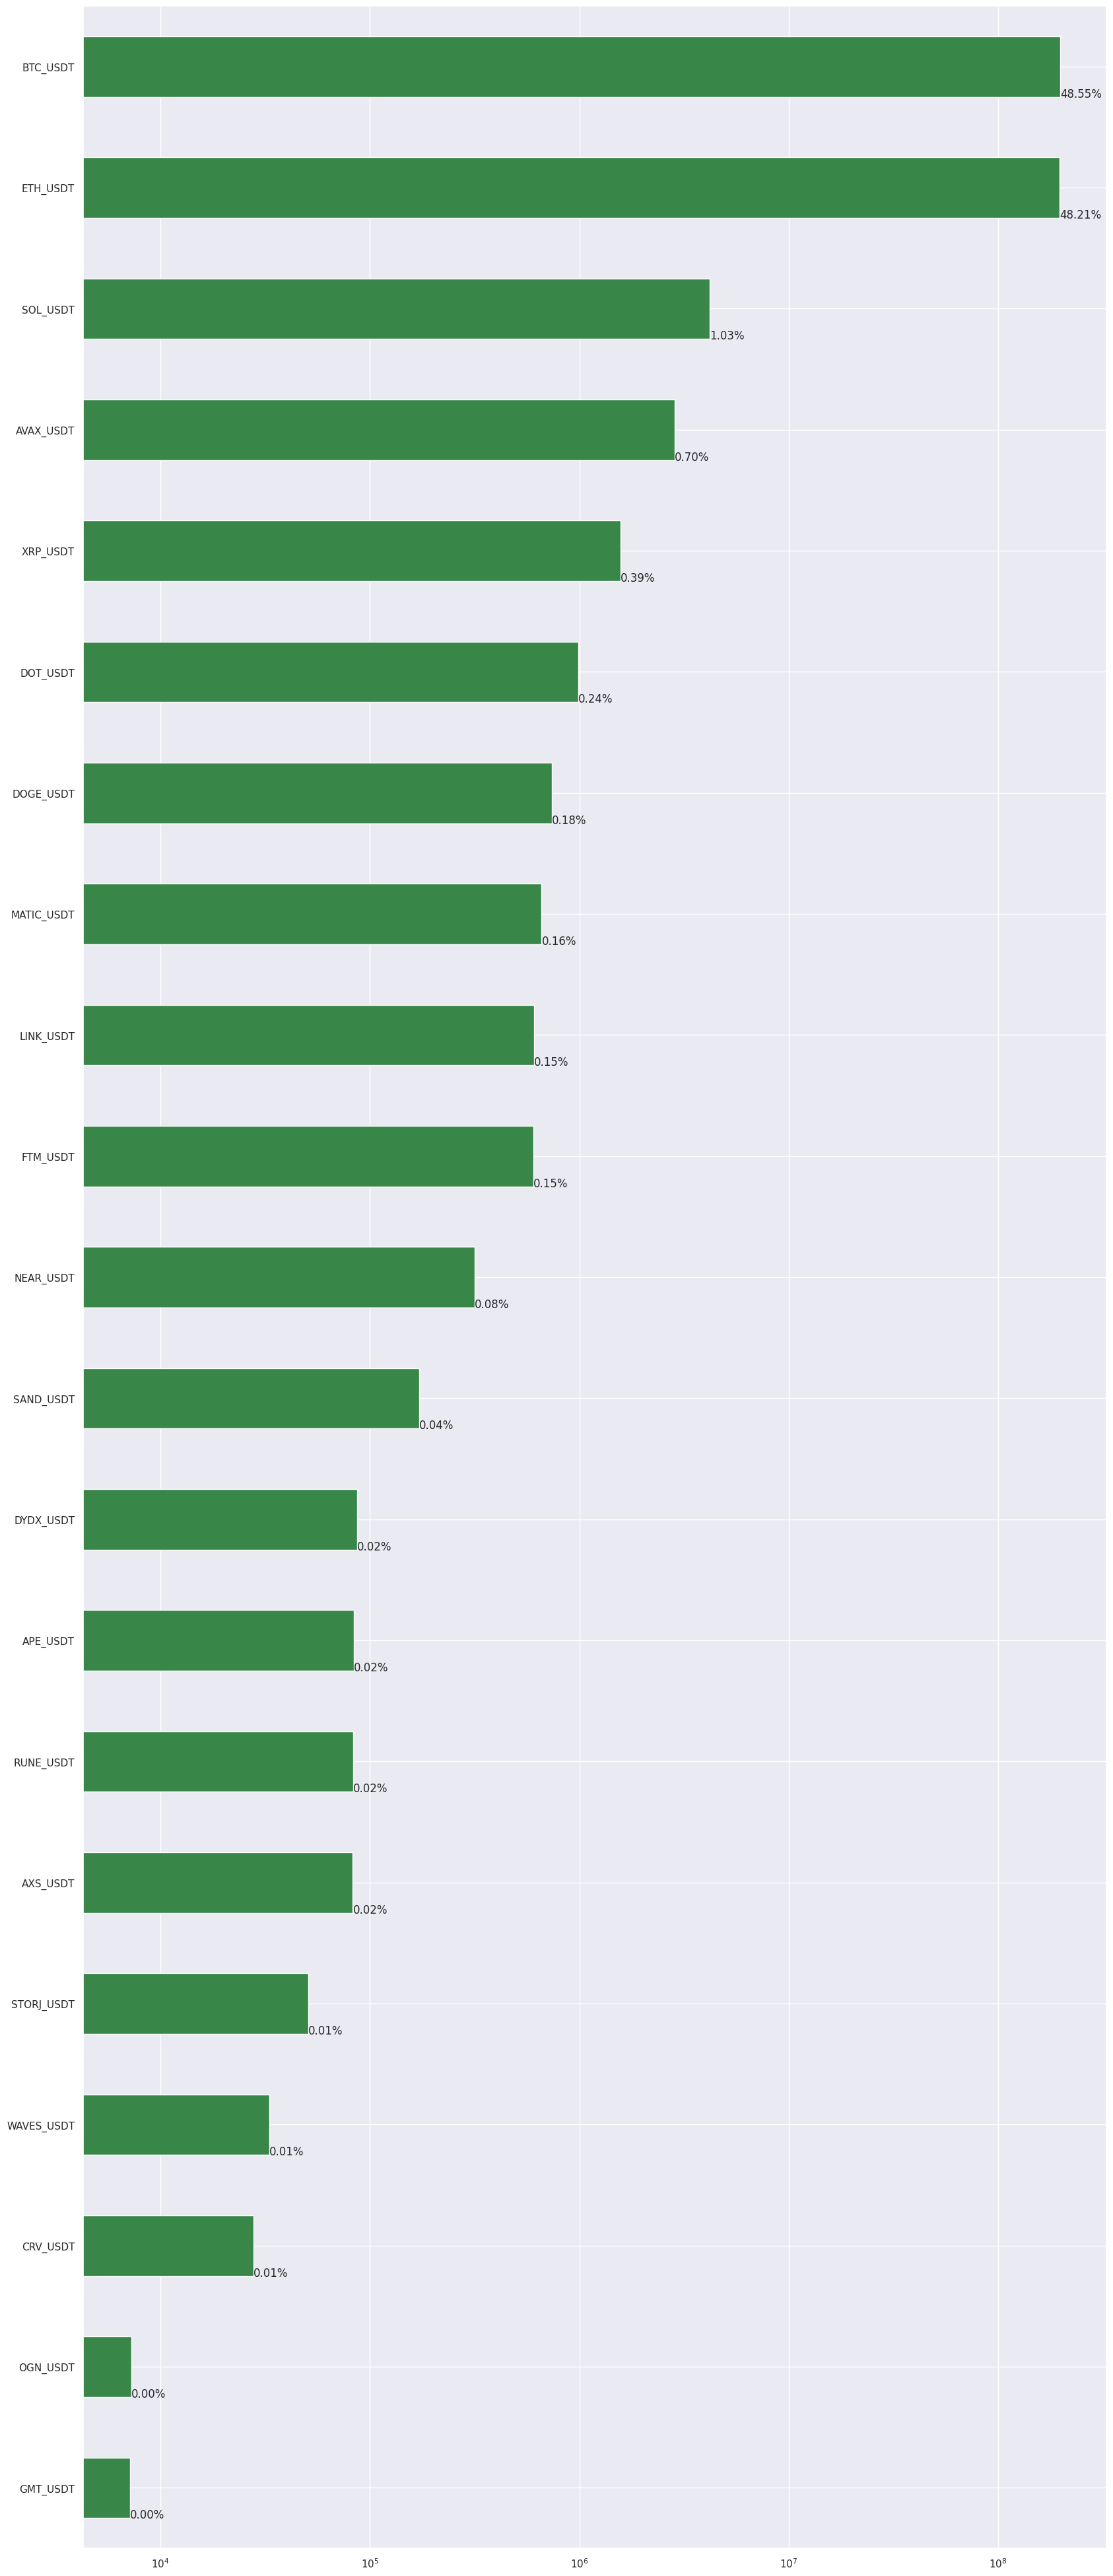

In [271]:
coplotti.plot_barplot(
    mdv_notional,
    annotation_mode="pct",
    orientation="horizontal",
    figsize=[20, 50],
    yscale="log",
)

In [281]:
cry_data.rename(columns={"currency_pair": "full_symbol"}, inplace=True)
cry_timestamp_stats = ramccqa.get_timestamp_stats(cry_data, vendor_name)
cry_timestamp_stats

,min_timestamp,max_timestamp,days_available
APE_USDT,2023-12-01 00:00:00,2024-01-01 00:00:00,31
AVAX_USDT,2023-12-01 00:00:00,2024-01-01 00:00:00,31
AXS_USDT,2023-12-01 00:00:00,2024-01-01 00:00:00,31
BTC_USDT,2023-12-01 00:00:00,2024-01-01 00:00:00,31
CRV_USDT,2023-12-01 00:00:00,2024-01-01 00:00:00,31
DOGE_USDT,2023-12-01 00:00:00,2024-01-01 00:00:00,31
DOT_USDT,2023-12-01 00:00:00,2024-01-01 00:00:00,31
DYDX_USDT,2023-12-01 00:00:00,2024-01-01 00:00:00,31
ETH_USDT,2023-12-01 00:00:00,2024-01-01 00:00:00,31
FTM_USDT,2023-12-01 00:00:00,2024-01-01 00:00:00,31


In [286]:
agg_level_full_symbol = ["full_symbol"]
cry_bad_data_stats = ramccqa.get_bad_data_stats(
    cry_data, agg_level_full_symbol, vendor_name
)
cry_bad_data_stats

/app/research_amp/cc/qa.py:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  symbol_data["full_symbol"] = symbol_data["full_symbol"].fillna(


,bad data [%],missing bars [%],volume=0 [%],NaNs [%]
APE_USDT,0.860196,0.0,0.860196,0.0
AVAX_USDT,0.089604,0.0,0.089604,0.0
AXS_USDT,0.439058,0.0,0.439058,0.0
BTC_USDT,0.000000,0.0,0.000000,0.0
CRV_USDT,0.450259,0.0,0.450259,0.0
DOGE_USDT,0.170247,0.0,0.170247,0.0
DOT_USDT,0.047042,0.0,0.047042,0.0
DYDX_USDT,0.674268,0.0,0.674268,0.0
ETH_USDT,0.000000,0.0,0.000000,0.0
FTM_USDT,0.064963,0.0,0.064963,0.0


In [287]:
agg_level_full_symbol_year_month = ["full_symbol", "year", "month"]
cry_bad_data_stats_by_year_month = ramccqa.get_bad_data_stats(
    cry_data, agg_level_full_symbol_year_month, vendor_name
)
cry_bad_data_stats_by_year_month

/app/research_amp/cc/qa.py:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  symbol_data["full_symbol"] = symbol_data["full_symbol"].fillna(


bad data [%]  missing bars [%]  volume=0 [%]  NaNs [%]
APE_USDT   2023 12      0.860215               0.0      0.860215       0.0
           2024 1       0.000000               0.0      0.000000       0.0
AVAX_USDT  2023 12      0.089606               0.0      0.089606       0.0
           2024 1       0.000000               0.0      0.000000       0.0
AXS_USDT   2023 12      0.439068               0.0      0.439068       0.0
           2024 1       0.000000               0.0      0.000000       0.0
BTC_USDT   2023 12      0.000000               0.0      0.000000       0.0
           2024 1       0.000000               0.0      0.000000       0.0
CRV_USDT   2023 12      0.450269               0.0      0.450269       0.0
           2024 1       0.000000               0.0      0.000000       0.0
DOGE_USDT  2023 12      0.170251               0.0      0.170251       0.0
           2024 1       0.000000               0.0      0.000000       0.0
DOT_USDT   2023 12      0.047043               0.0      0.047043       0.0
           2024 1       0.000000               0.0      0.000000       0.0
DYDX_USDT  2023 12      0.674283               0.0      0.674283       0.0
           2024 1       0.000000               0.0      0.000000       0.0
ETH_USDT   2023 12      0.000000               0.0      0.000000       0.0
           2024 1       0.000000               0.0      0.000000       0.0
FTM_USDT   2023 12      0.064964               0.0      0.064964       0.0
           2024 1       0.000000               0.0      0.000000       0.0
GMT_USDT   2023 12      0.076165               0.0      0.076165       0.0
           2024 1       0.000000               0.0      0.000000       0.0
LINK_USDT  2023 12      0.067204               0.0      0.067204       0.0
           2024 1       0.000000               0.0      0.000000       0.0
MATIC_USDT 2023 12      0.221774               0.0      0.221774       0.0
           2024 1       0.000000               0.0      0.000000       0.0
NEAR_USDT  2023 12      0.071685               0.0      0.071685       0.0
           2024 1       0.000000               0.0      0.000000       0.0
OGN_USDT   2023 12      0.374104               0.0      0.374104       0.0
           2024 1       0.000000               0.0      0.000000       0.0
RUNE_USDT  2023 12      0.799731               0.0      0.799731       0.0
           2024 1       0.000000               0.0      0.000000       0.0
SAND_USDT  2023 12      0.168011               0.0      0.168011       0.0
           2024 1       0.000000               0.0      0.000000       0.0
SOL_USDT   2023 12      0.080645               0.0      0.080645       0.0
           2024 1       0.000000               0.0      0.000000       0.0
STORJ_USDT 2023 12      0.452509               0.0      0.452509       0.0
           2024 1       0.000000               0.0      0.000000       0.0
WAVES_USDT 2023 12      0.293459               0.0      0.293459       0.0
           2024 1       0.000000               0.0      0.000000       0.0
XRP_USDT   2023 12      0.026882               0.0      0.026882       0.0
           2024 1       0.000000               0.0      0.000000       0.0

/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


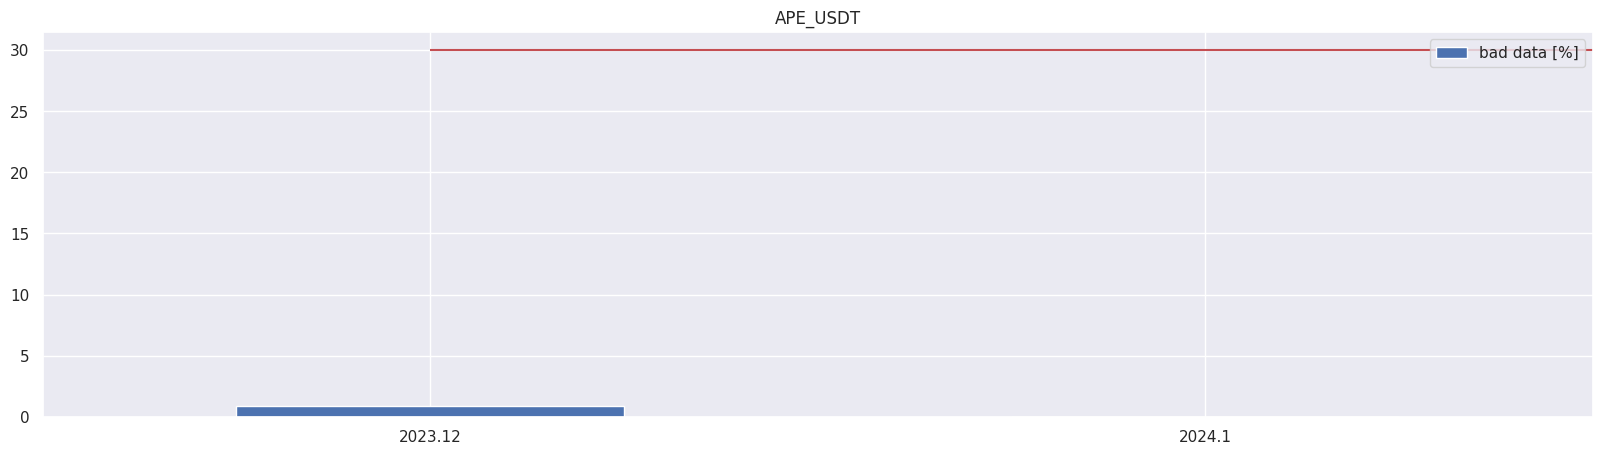

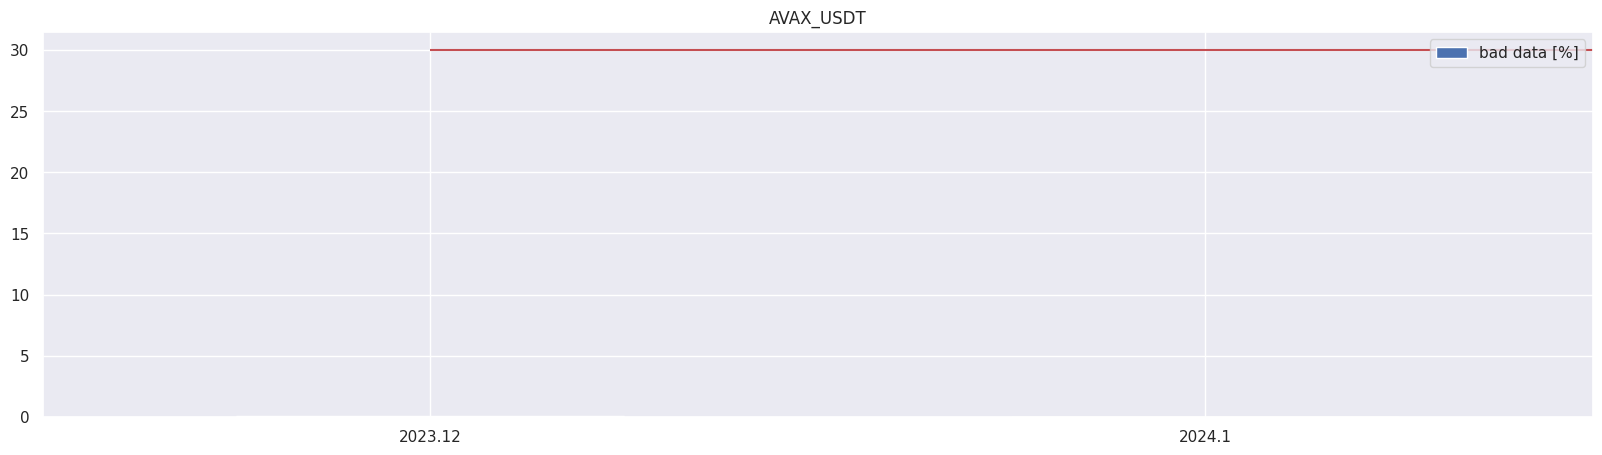

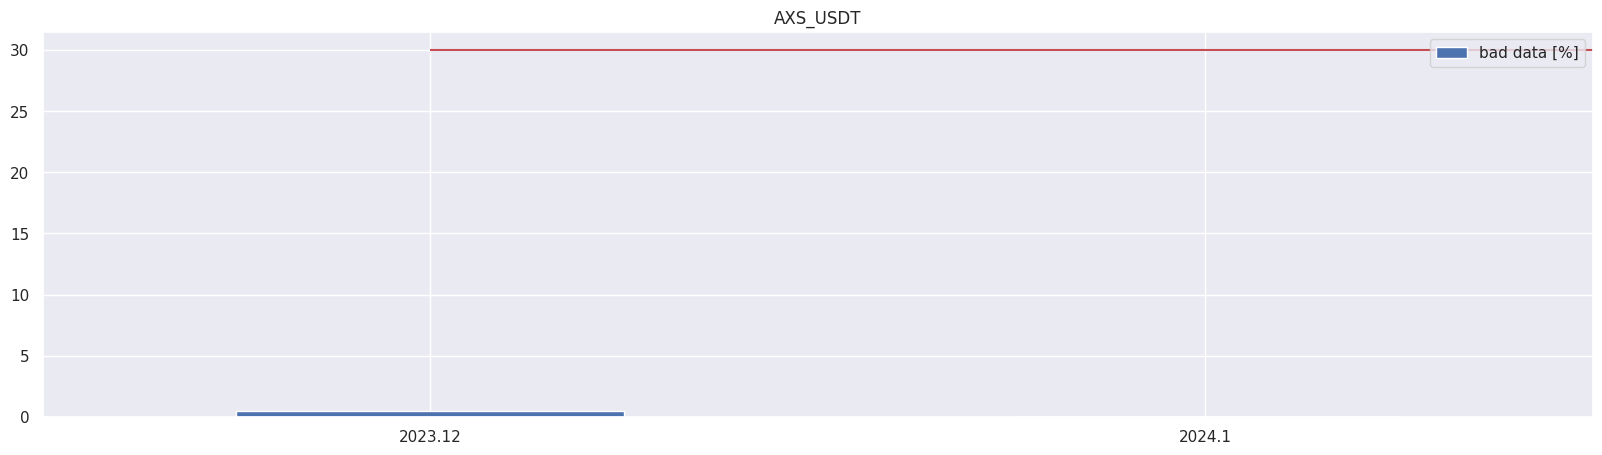

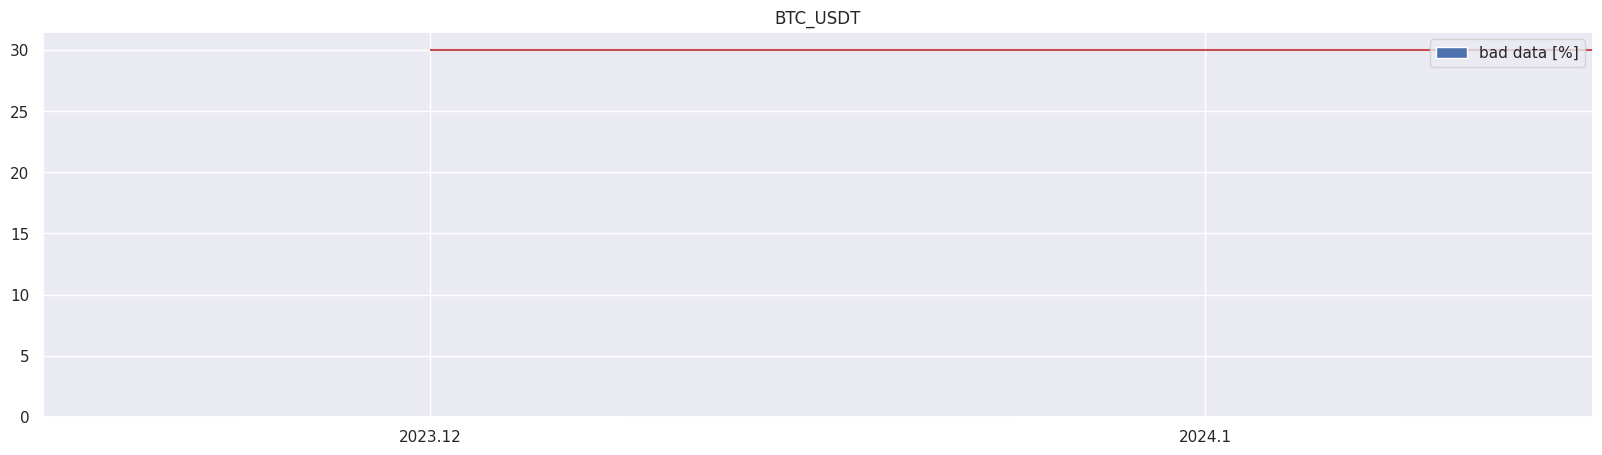

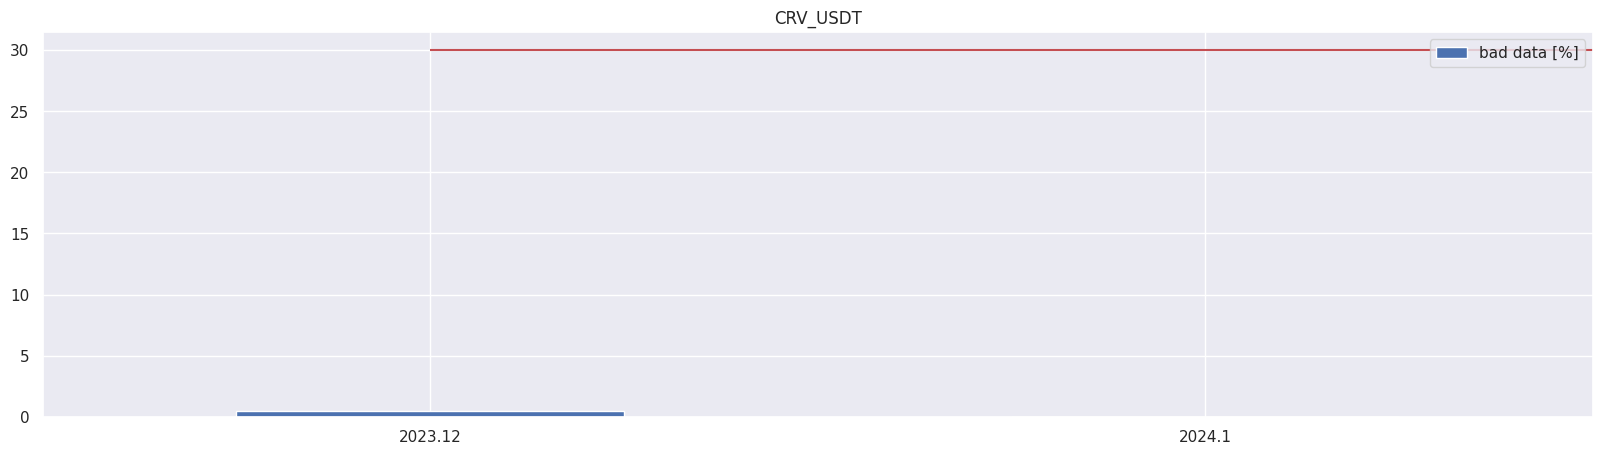

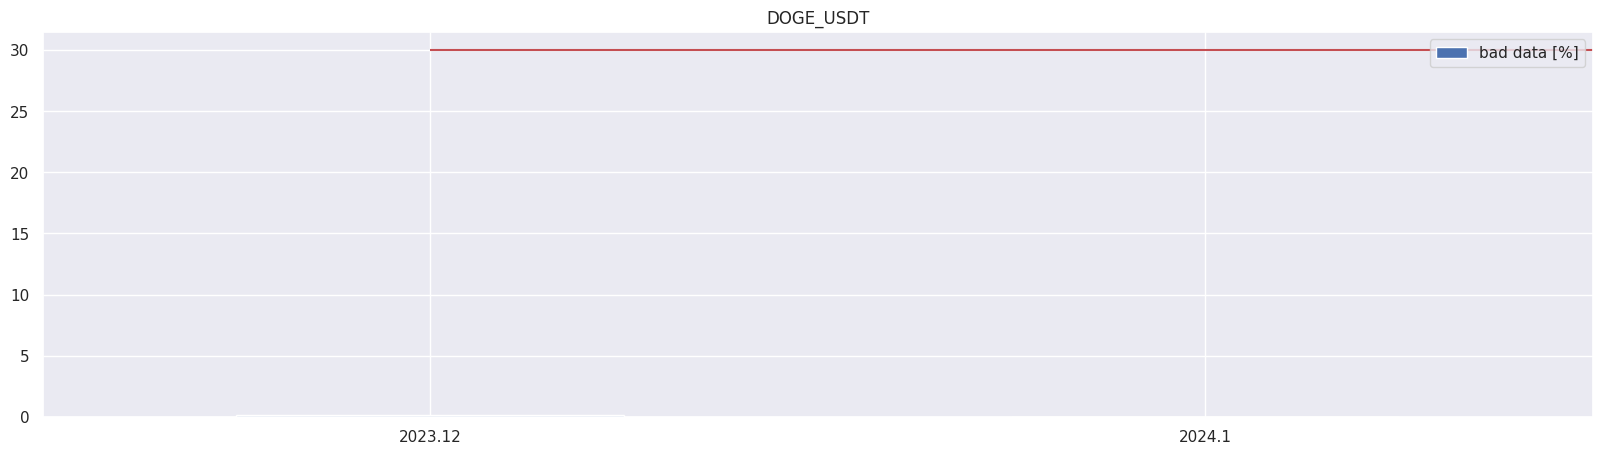

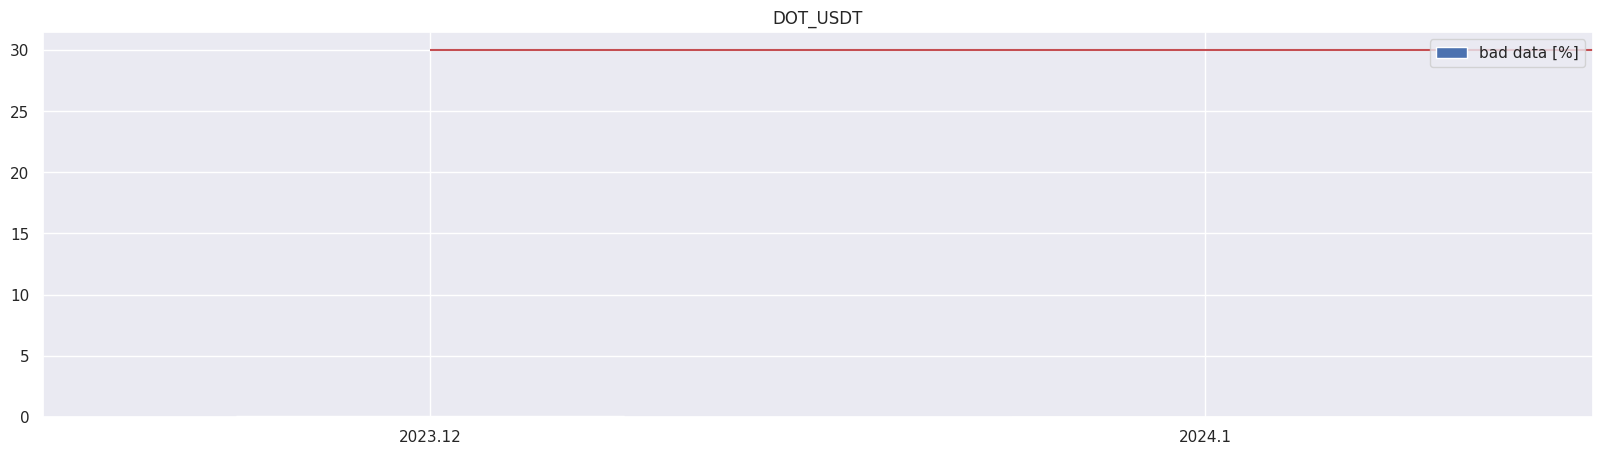

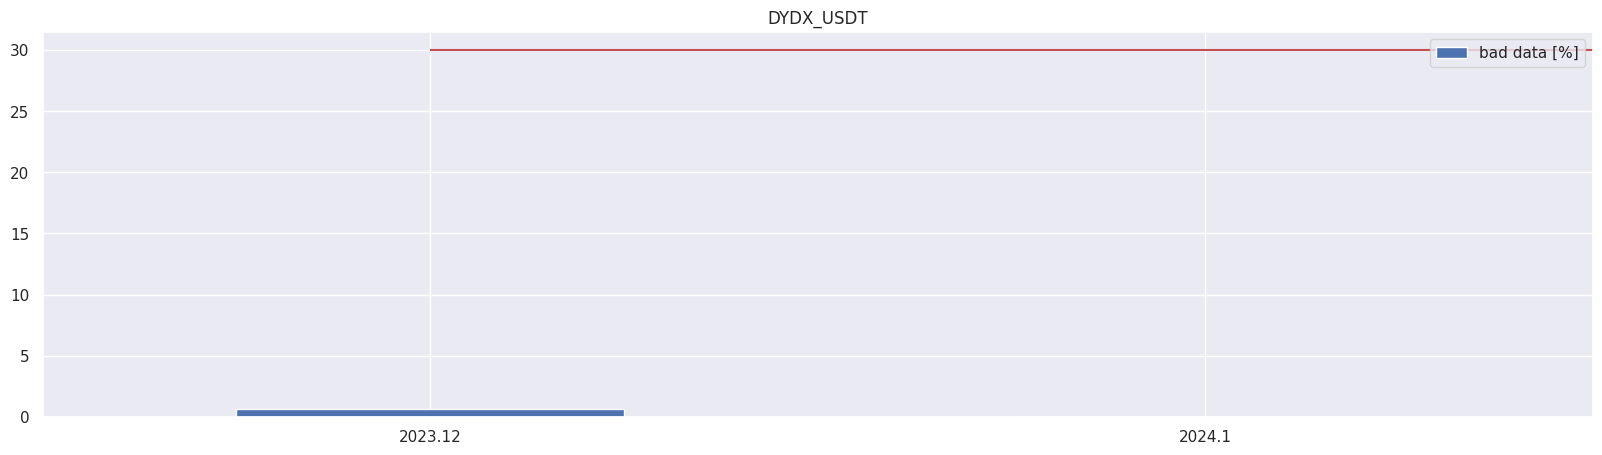

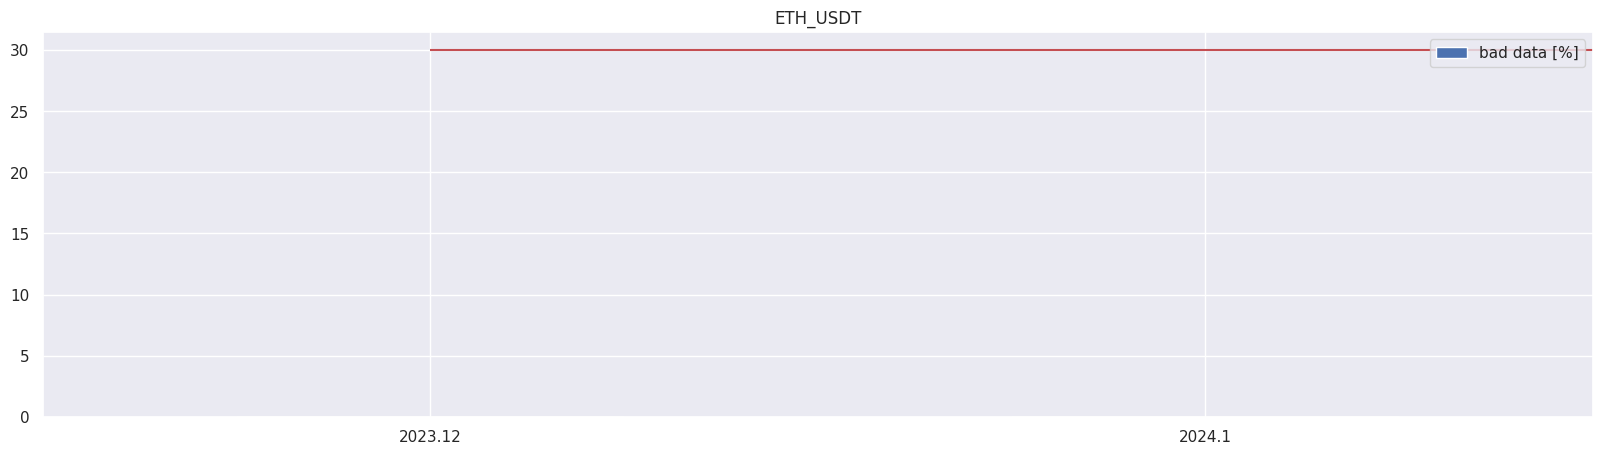

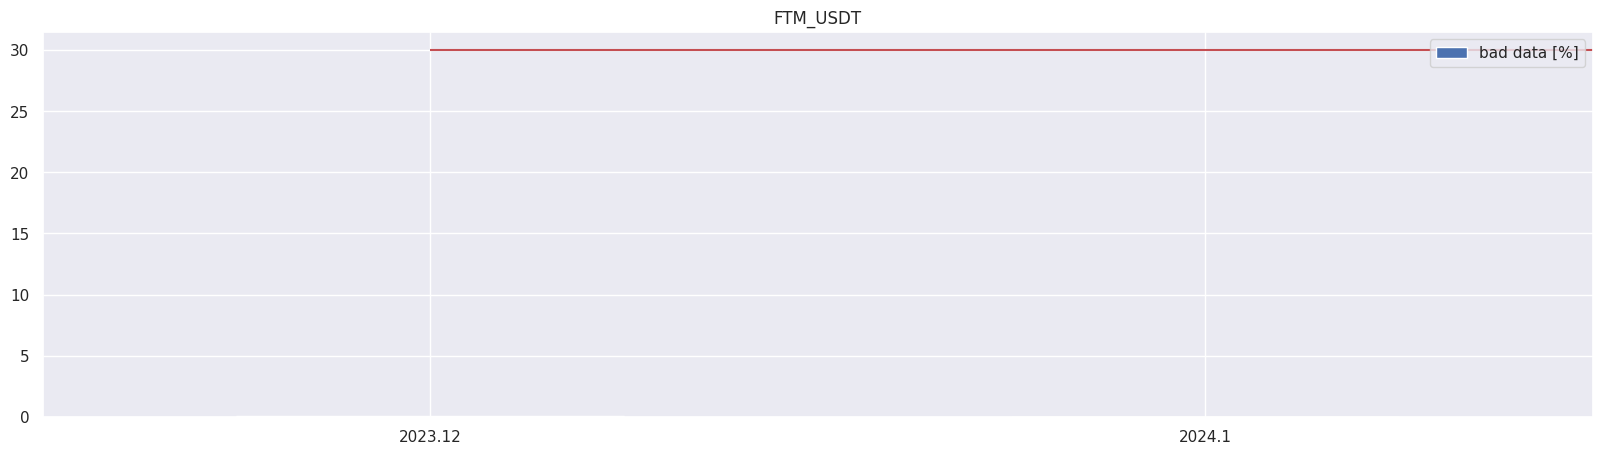

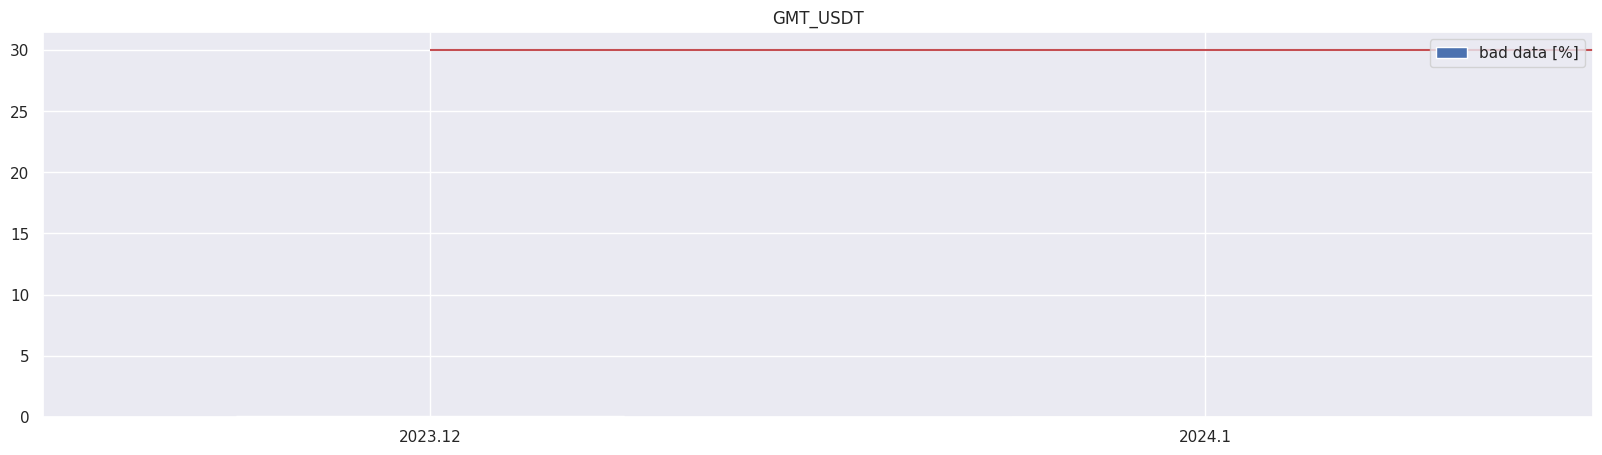

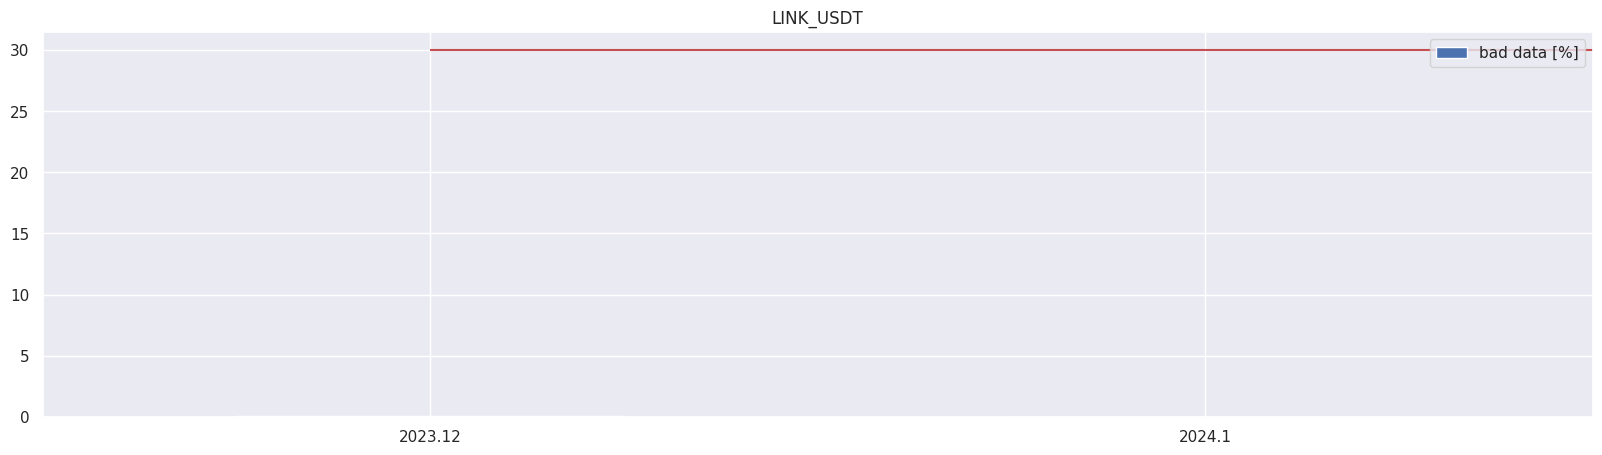

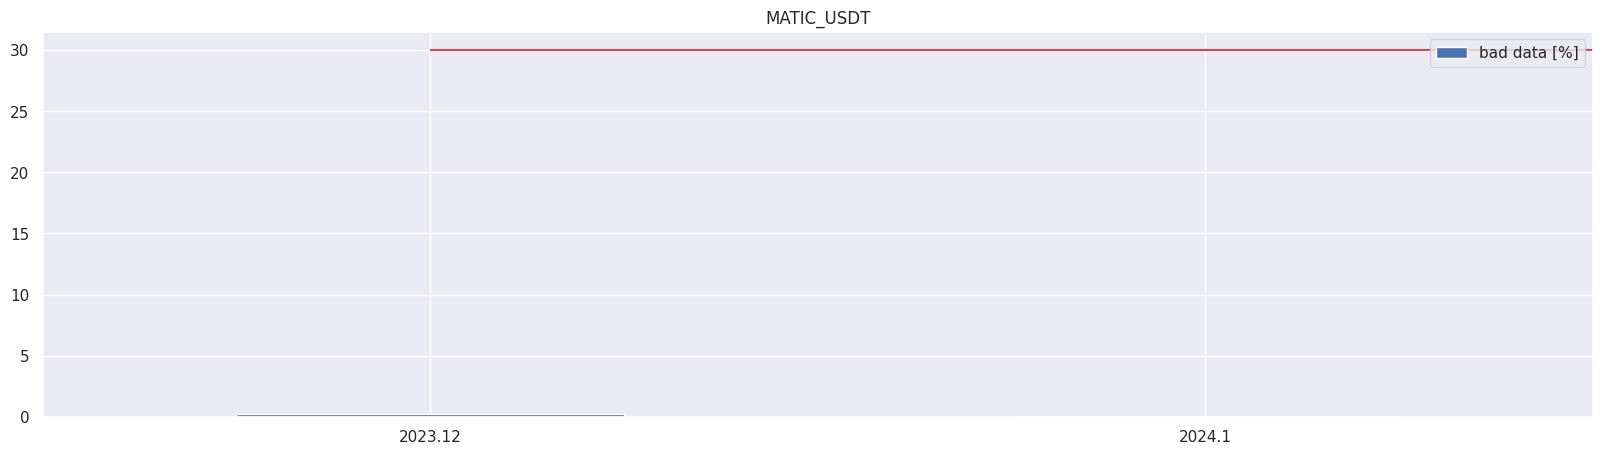

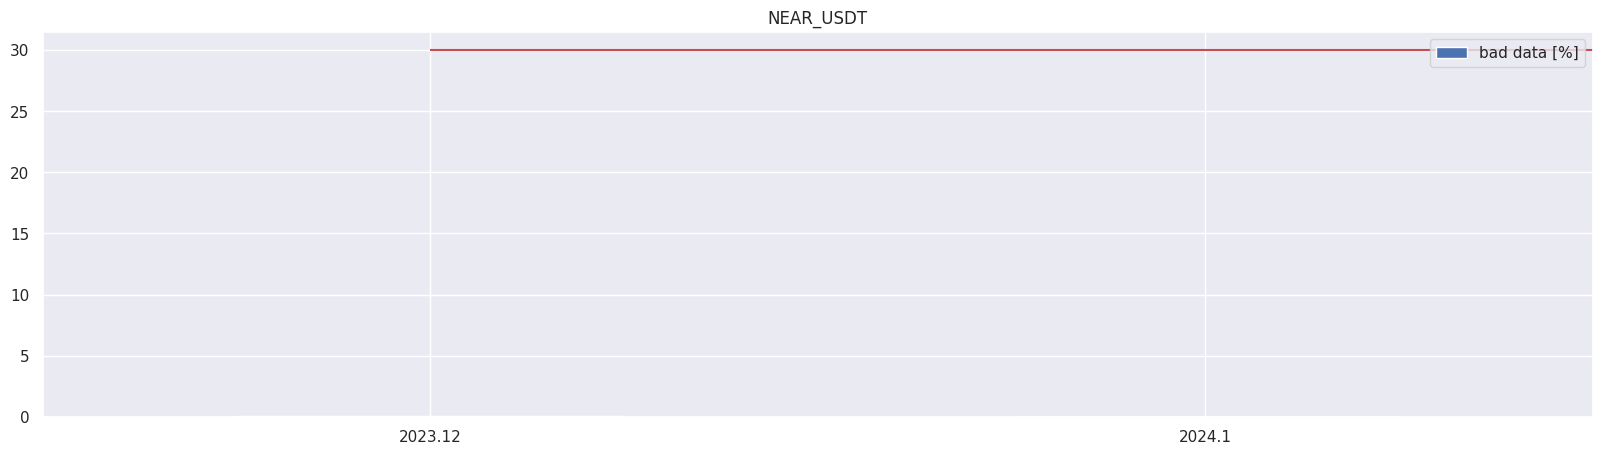

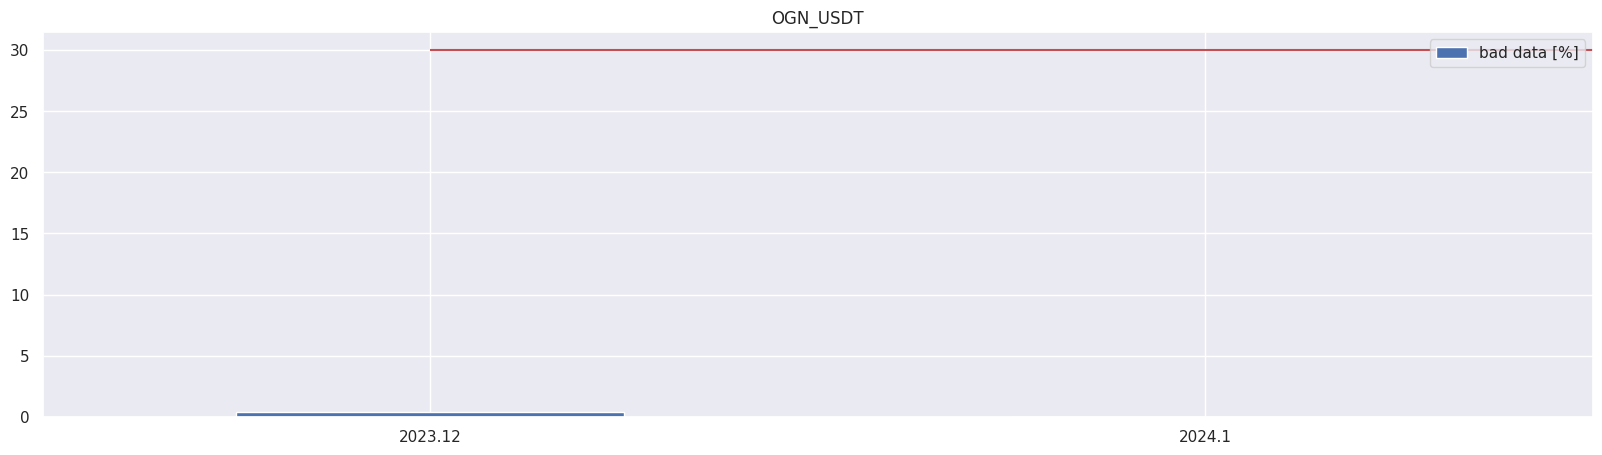

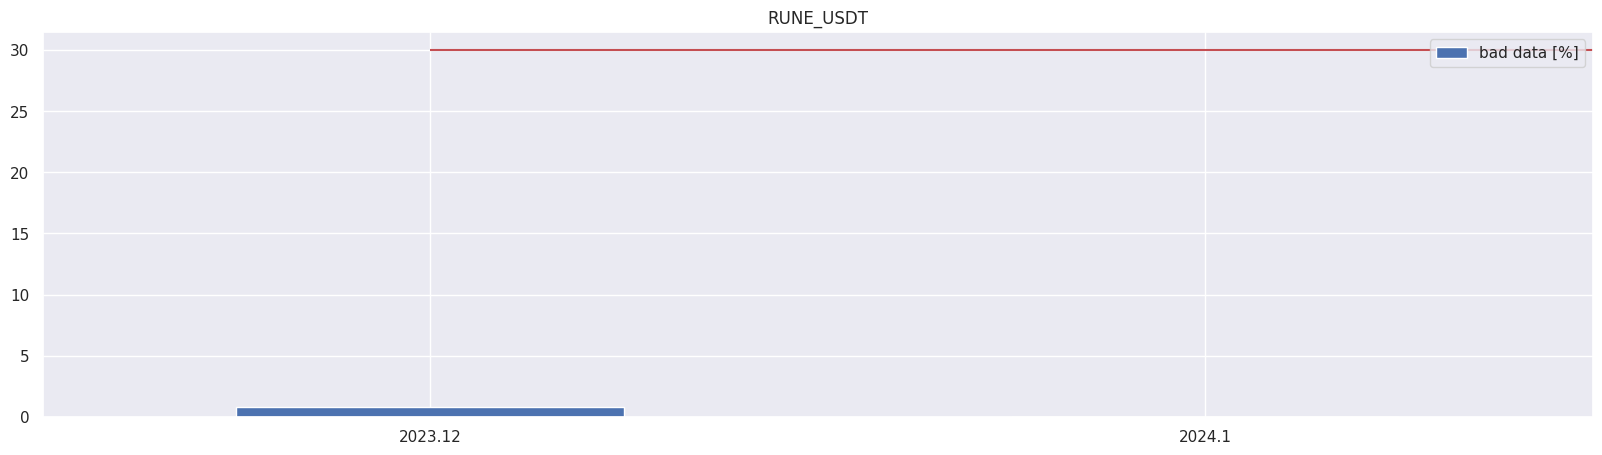

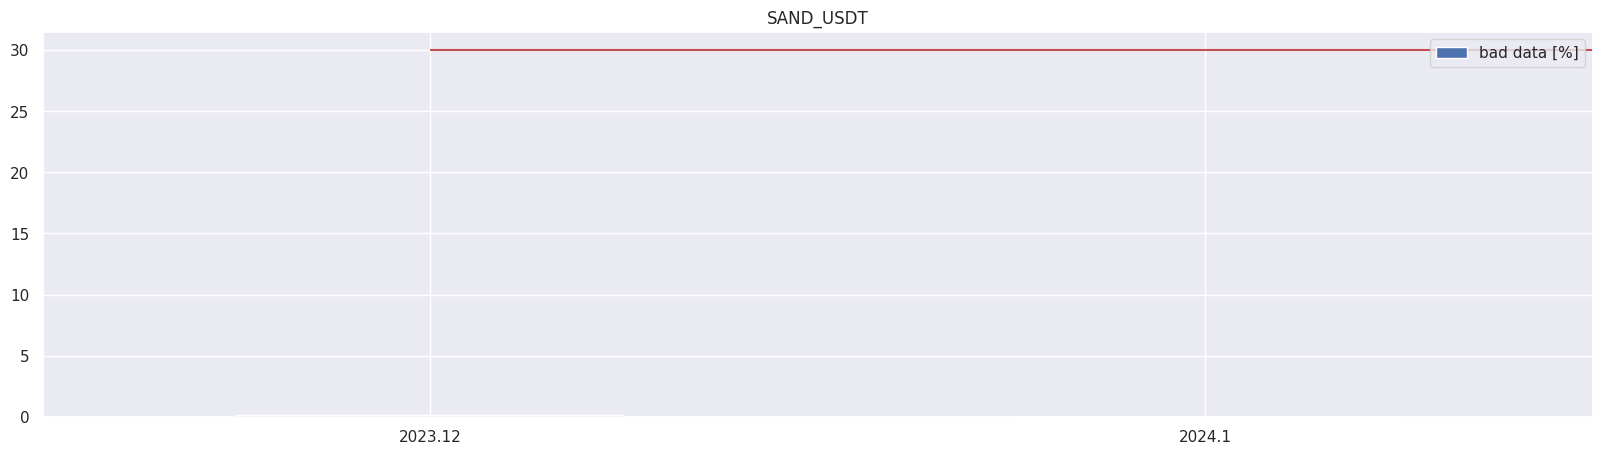

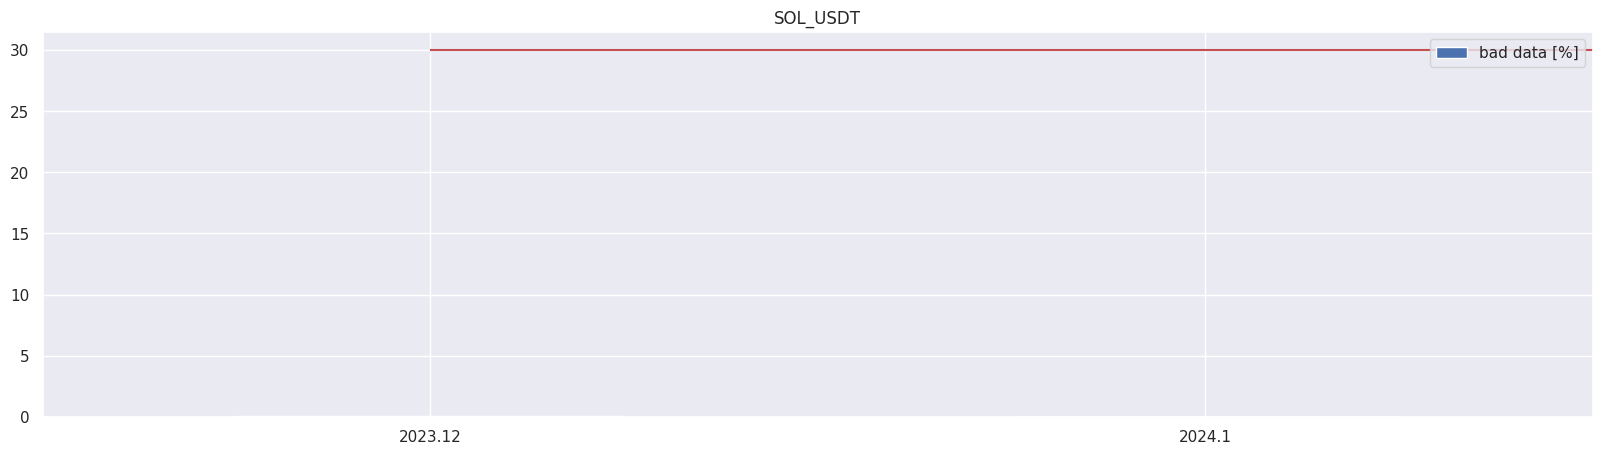

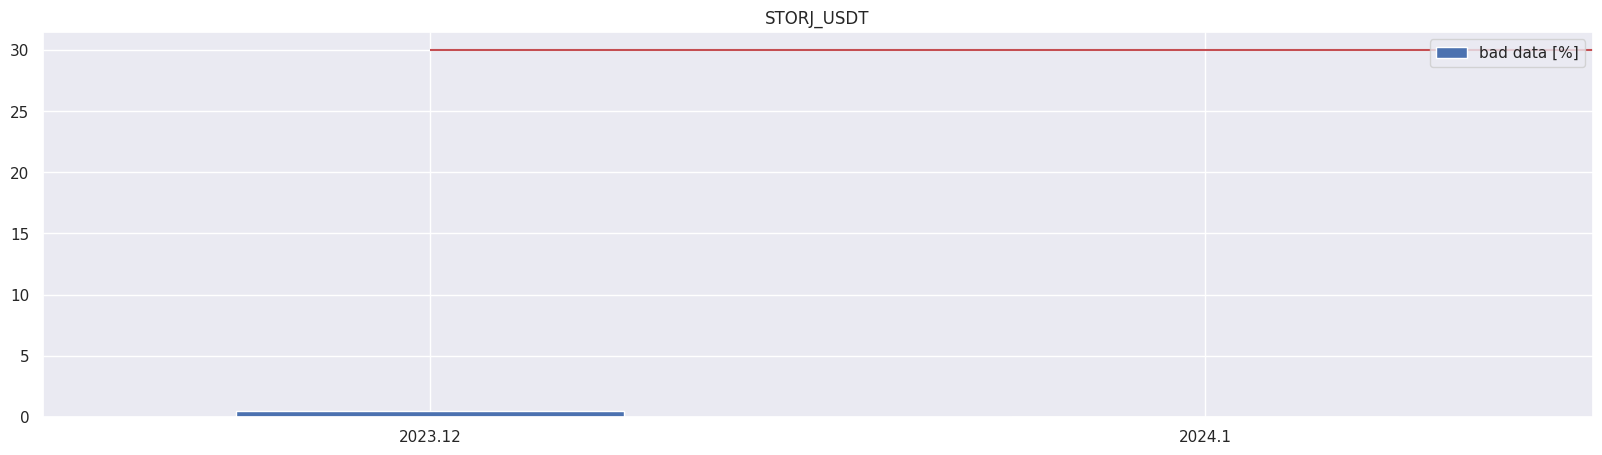

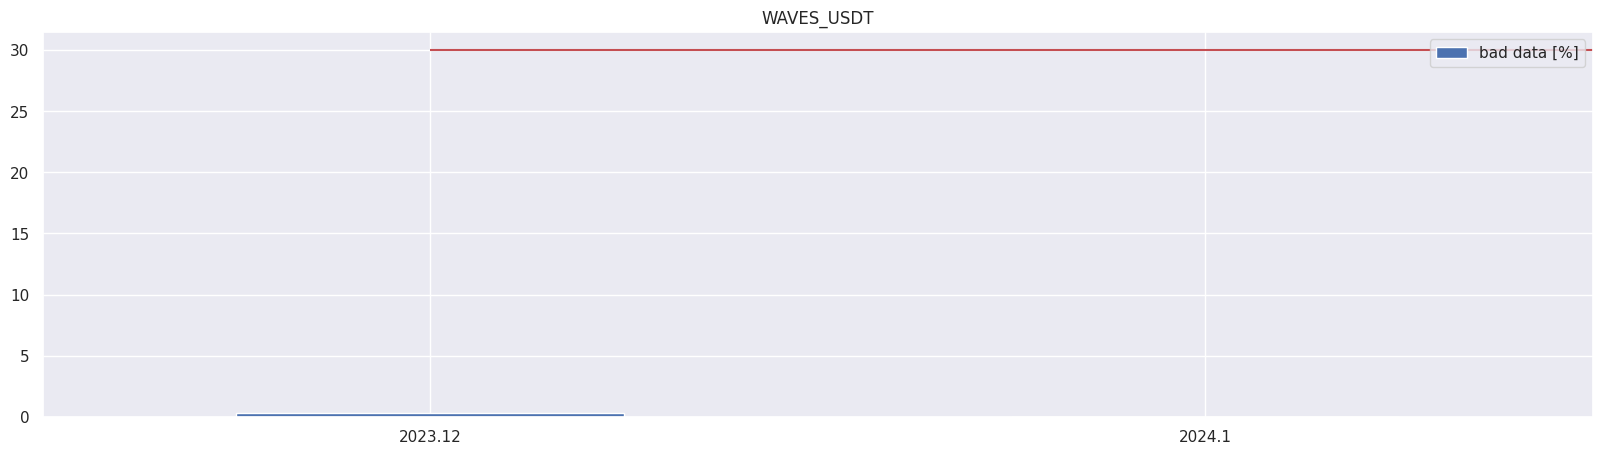

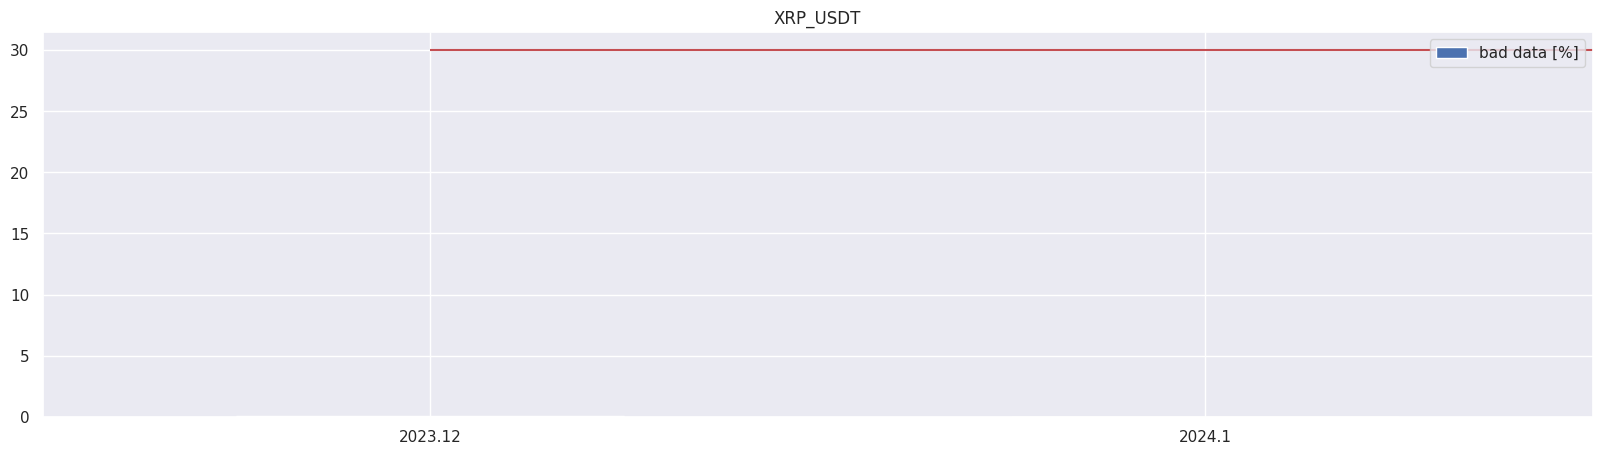

In [288]:
_ = ramccqa.plot_bad_data_by_year_month_stats(
    cry_bad_data_stats_by_year_month, 30
)

# Perpetual Symbols Analysis

In [328]:
perp_data = pd.DataFrame()
universe_list = [
    "ETH/USD:USD",  # Symbols from universe 7.4
    "BTC/USD:USD",
    "SAND/USD:USD",
    "STORJ/USD:USD",
    "GMT/USD:USD",
    "AVAX/USD:USD",
    #                  'BNB_USDT', not in the market
    "APE/USD:USD",
    "MATIC/USD:USD",
    "DYDX/USD:USD",
    "DOT/USD:USD",
    #                  'UNFI_USDT', not in the market
    "LINK/USD:USD",
    "XRP/USD:USD",
    "CRV/USD:USD",
    "RUNE/USD:USD",
    #                  'BAKE_USDT', not in the market
    "NEAR/USD:USD",
    "FTM/USD:USD",
    "WAVES/USD:USD",
    "AXS/USD:USD",
    "OGN/USD:USD",
    "DOGE/USD:USD",
    "SOL/USD:USD",
]
#                  'CTK_USDT'] not in the market
for symbol in universe_list:
    ohlcv = _download_OHLCV_data(
        config["start_timestamp"],
        config["end_timestamp"],
        symbol,
    )
    perp_data = pd.concat([ohlcv, perp_data], ignore_index=True)
perp_data

,timestamp,open,high,low,close,volume,currency_pair
0,1701388800000,59.274,59.356,59.274,59.356,0.2000,SOL/USD:USD
1,1701388860000,59.388,59.416,59.339,59.339,0.3000,SOL/USD:USD
2,1701388920000,59.309,59.309,59.225,59.225,2.2000,SOL/USD:USD
3,1701388980000,59.227,59.227,59.188,59.190,0.3000,SOL/USD:USD
4,1701389040000,59.211,59.227,59.211,59.218,2.3000,SOL/USD:USD
...,...,...,...,...,...,...,...
937456,1704066960000,2280.670,2281.290,2279.740,2281.010,135.6773,ETH/USD:USD
937457,1704067020000,2281.070,2282.250,2281.070,2282.120,65.6578,ETH/USD:USD
937458,1704067080000,2282.100,2282.980,2282.100,2282.850,35.1856,ETH/USD:USD
937459,1704067140000,2282.800,2282.800,2281.610,2282.170,81.7392,ETH/USD:USD


In [329]:
try:
    dataset_validator.run_all_checks([perp_data])
except Exception as e:
    # Pass information about success or failure of the QA
    #  back to the task that invoked it.
    data_qa_outcome = str(e)
    raise e
# If no exception was raised mark the QA as successful.
data_qa_outcome = "SUCCESS"

INFO  Running all QA checks:
INFO  	GapsInTimeIntervalBySymbolsCheck: PASSED
INFO  	NaNChecks: PASSED
INFO  	OhlcvLogicalValuesCheck: PASSED


In [330]:
perp_data2 = perp_data.copy(deep=True)
perp_data2 = perp_data2.reset_index()
perp_data2["normal_timestamp"] = pd.to_datetime(
    perp_data2["timestamp"], unit="ms"
)
perp_data2.set_index("normal_timestamp", inplace=True)
perp_cry_data = perp_data2.copy(deep=True)
perp_data2

,index,timestamp,open,high,low,close,volume,currency_pair
normal_timestamp,,,,,,,,
2023-12-01 00:00:00,0,1701388800000,59.274,59.356,59.274,59.356,0.2000,SOL/USD:USD
2023-12-01 00:01:00,1,1701388860000,59.388,59.416,59.339,59.339,0.3000,SOL/USD:USD
2023-12-01 00:02:00,2,1701388920000,59.309,59.309,59.225,59.225,2.2000,SOL/USD:USD
2023-12-01 00:03:00,3,1701388980000,59.227,59.227,59.188,59.190,0.3000,SOL/USD:USD
2023-12-01 00:04:00,4,1701389040000,59.211,59.227,59.211,59.218,2.3000,SOL/USD:USD
...,...,...,...,...,...,...,...,...
2023-12-31 23:56:00,937456,1704066960000,2280.670,2281.290,2279.740,2281.010,135.6773,ETH/USD:USD
2023-12-31 23:57:00,937457,1704067020000,2281.070,2282.250,2281.070,2282.120,65.6578,ETH/USD:USD
2023-12-31 23:58:00,937458,1704067080000,2282.100,2282.980,2282.100,2282.850,35.1856,ETH/USD:USD


In [331]:
perp_df = convert_to_multiindex(perp_data2, "currency_pair")
perp_df

close                                                                                                                                                                                                                                                                     high                                                                                                                                                                                                                                                                    index                                                                                                                                                                                                                                                                      low                                                                                                                                                                     \
                    APE/USD:USD AVAX/USD:USD AXS/USD:USD BTC/USD:USD CRV/USD:USD DOGE/USD:USD DOT/USD:USD DYDX/USD:USD ETH/USD:USD FTM/USD:USD GMT/USD:USD LINK/USD:USD MATIC/USD:USD NEAR/USD:USD OGN/USD:USD RUNE/USD:USD SAND/USD:USD SOL/USD:USD STORJ/USD:USD WAVES/USD:USD XRP/USD:USD APE/USD:USD AVAX/USD:USD AXS/USD:USD BTC/USD:USD CRV/USD:USD DOGE/USD:USD DOT/USD:USD DYDX/USD:USD ETH/USD:USD FTM/USD:USD GMT/USD:USD LINK/USD:USD MATIC/USD:USD NEAR/USD:USD OGN/USD:USD RUNE/USD:USD SAND/USD:USD SOL/USD:USD STORJ/USD:USD WAVES/USD:USD XRP/USD:USD APE/USD:USD AVAX/USD:USD AXS/USD:USD BTC/USD:USD CRV/USD:USD DOGE/USD:USD DOT/USD:USD DYDX/USD:USD ETH/USD:USD FTM/USD:USD GMT/USD:USD LINK/USD:USD MATIC/USD:USD NEAR/USD:USD OGN/USD:USD RUNE/USD:USD SAND/USD:USD SOL/USD:USD STORJ/USD:USD WAVES/USD:USD XRP/USD:USD APE/USD:USD AVAX/USD:USD AXS/USD:USD BTC/USD:USD CRV/USD:USD DOGE/USD:USD DOT/USD:USD DYDX/USD:USD ETH/USD:USD FTM/USD:USD GMT/USD:USD LINK/USD:USD MATIC/USD:USD NEAR/USD:USD   
normal_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2023-12-01 00:00:00      1.5732       21.419       6.363     37749.0      0.5584     0.083456      5.4830       3.2460     2053.41     0.30380     0.26210       14.422       0.76312       1.8827     0.12895       6.4290      0.40888      59.356       0.73190        2.0780     0.60653      1.5737       21.419       6.363     37755.8      0.5584     0.083469      5.4830       3.2510     2053.87     0.30380     0.26210       14.422       0.76312       1.8827     0.12895       6.4550      0.40888      59.356       0.73270        2.0790     0.60653      624974       669615      133923      848179      357128        44641      491051       535692      892820      223205      714256       446410        580333       267846       89282       312487       803538           0        758897        178564      401769      1.5720       21.393       6.361     37730.7      0.5584     0.083456      5.4790       3.2460     2052.43     0.30350     0.26210       14.413       0.76272       1.8786   
2023-12-01 00:01:00      1.5711       21.414       6.3

In [332]:
resampled_perp_data = dtfasycxut.resample_ohlcv_data(perp_df, "1T")
resampled_perp_data

close                                                                                                                                                                                                                                                                     high                                                                                                                                                                                                                                                                      low                                                                                                                                                                                                                                                                     open                                                                                                                                                                     \
                    APE/USD:USD AVAX/USD:USD AXS/USD:USD BTC/USD:USD CRV/USD:USD DOGE/USD:USD DOT/USD:USD DYDX/USD:USD ETH/USD:USD FTM/USD:USD GMT/USD:USD LINK/USD:USD MATIC/USD:USD NEAR/USD:USD OGN/USD:USD RUNE/USD:USD SAND/USD:USD SOL/USD:USD STORJ/USD:USD WAVES/USD:USD XRP/USD:USD APE/USD:USD AVAX/USD:USD AXS/USD:USD BTC/USD:USD CRV/USD:USD DOGE/USD:USD DOT/USD:USD DYDX/USD:USD ETH/USD:USD FTM/USD:USD GMT/USD:USD LINK/USD:USD MATIC/USD:USD NEAR/USD:USD OGN/USD:USD RUNE/USD:USD SAND/USD:USD SOL/USD:USD STORJ/USD:USD WAVES/USD:USD XRP/USD:USD APE/USD:USD AVAX/USD:USD AXS/USD:USD BTC/USD:USD CRV/USD:USD DOGE/USD:USD DOT/USD:USD DYDX/USD:USD ETH/USD:USD FTM/USD:USD GMT/USD:USD LINK/USD:USD MATIC/USD:USD NEAR/USD:USD OGN/USD:USD RUNE/USD:USD SAND/USD:USD SOL/USD:USD STORJ/USD:USD WAVES/USD:USD XRP/USD:USD APE/USD:USD AVAX/USD:USD AXS/USD:USD BTC/USD:USD CRV/USD:USD DOGE/USD:USD DOT/USD:USD DYDX/USD:USD ETH/USD:USD FTM/USD:USD GMT/USD:USD LINK/USD:USD MATIC/USD:USD NEAR/USD:USD   
normal_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2023-12-01 00:00:00      1.5732       21.419       6.363     37749.0      0.5584     0.083456      5.4830       3.2460     2053.41     0.30380     0.26210       14.422       0.76312       1.8827     0.12895       6.4290      0.40888      59.356       0.73190        2.0780     0.60653      1.5737       21.419       6.363     37755.8      0.5584     0.083469      5.4830       3.2510     2053.87     0.30380     0.26210       14.422       0.76312       1.8827     0.12895       6.4550      0.40888      59.356       0.73270        2.0790     0.60653      1.5720       21.393       6.361     37730.7      0.5584     0.083456      5.4790       3.2460     2052.43     0.30350     0.26210       14.413       0.76272       1.8786     0.12895       6.4290      0.40877      59.274       0.73190        2.0780     0.60641      1.5720       21.393       6.363     37735.9      0.5584     0.083469      5.4790       3.2510     2052.73     0.30350     0.26210       14.413       0.76272       1.8786   
2023-12-01 00:01:00      1.5711       21.414       6.3

In [333]:
volume_notional = resampled_perp_data["volume"] * resampled_perp_data["close"]
volume_notional

,APE/USD:USD,AVAX/USD:USD,AXS/USD:USD,BTC/USD:USD,CRV/USD:USD,DOGE/USD:USD,DOT/USD:USD,DYDX/USD:USD,ETH/USD:USD,FTM/USD:USD,GMT/USD:USD,LINK/USD:USD,MATIC/USD:USD,NEAR/USD:USD,OGN/USD:USD,RUNE/USD:USD,SAND/USD:USD,SOL/USD:USD,STORJ/USD:USD,WAVES/USD:USD,XRP/USD:USD
normal_timestamp,,,,,,,,,,,,,,,,,,,,,
2023-12-01 00:00:00,4.7196,6.4257,1.9089,144891.98670,0.5584,1.66912,1.64490,0.97380,243569.949993,0.91140,0.52420,868.2044,1.52624,3.7654,1.2895,1.28580,1.22664,11.8712,2.19570,2.49360,1.21306
2023-12-01 00:01:00,4.7133,2.1414,1.2712,117818.53419,1.6734,2.50452,1.09560,0.64740,148347.297466,0.60740,0.78540,2589.6567,2.28771,3.7648,2.5770,1.29380,1.22637,17.8017,2.19390,0.41560,1.81875
2023-12-01 00:02:00,3.1396,6.4122,1.2702,53838.11276,1.1144,1.66794,1.64130,28.98000,197155.861356,0.90930,1.04360,3166.5787,2.28366,3.7586,2.5770,1.28960,0.81574,130.2950,0.73060,0.62220,0.60621
2023-12-01 00:03:00,4.7169,4.2710,1.9038,40691.02653,1.6716,1.66942,1.09420,1.61650,184576.850214,0.60620,0.78270,2.8790,2.28345,3.7558,3.8529,1.93230,0.81616,17.7570,1.46120,0.62250,1.81842
2023-12-01 00:04:00,3.1502,4.2708,1.2692,110785.84758,1.6731,1.67080,1.64070,1.93740,144590.372500,0.90930,0.78270,580.2797,1.52302,5.6355,3.8574,1.92480,0.81610,136.2014,1.46140,0.41500,0.60609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:56:00,3.2344,11.5503,2.6517,198196.16838,2.4168,1.78840,2.45691,0.29407,309481.278073,0.94378,0.95688,1.4916,2.90895,10.9494,2.7934,1.02222,1.19136,50.7100,2.10129,0.53480,1.22876
2023-12-31 23:57:00,3.2384,7.7108,2.6541,170752.62620,1.2082,2.68515,4.91952,0.88398,149838.978536,1.42026,0.63804,2.9860,1.94090,7.3000,4.1928,1.02392,1.19542,30.4527,1.40460,0.53544,1.84722
2023-12-31 23:58:00,4.8606,11.5641,1.7716,237471.13945,1.2094,1.79068,2.46000,0.29455,80323.446960,1.42185,0.95472,4.4844,2.91180,3.6525,2.7952,1.02312,2.39088,20.3226,1.40522,0.80343,0.61546


In [334]:
# Compute mean daily notional volume.
mdv_notional = volume_notional.resample("D").sum().mean()
mdv_notional = mdv_notional.sort_values().round(2)
mdv_notional.name = "mdv_notional"
mdv_notional

WAVES/USD:USD    1.703400e+03
GMT/USD:USD      2.772960e+03
OGN/USD:USD      4.584760e+03
CRV/USD:USD      5.221410e+03
SAND/USD:USD     7.506490e+03
RUNE/USD:USD     7.673660e+03
APE/USD:USD      8.557420e+03
DYDX/USD:USD     9.835330e+03
FTM/USD:USD      1.118882e+04
AXS/USD:USD      1.490526e+04
MATIC/USD:USD    1.869297e+04
STORJ/USD:USD    2.216451e+04
NEAR/USD:USD     2.227997e+04
DOGE/USD:USD     2.331112e+04
DOT/USD:USD      3.346319e+04
XRP/USD:USD      7.738952e+04
AVAX/USD:USD     1.070112e+05
LINK/USD:USD     2.743006e+05
SOL/USD:USD      5.025196e+05
ETH/USD:USD      4.278573e+08
BTC/USD:USD      4.834488e+08
Name: mdv_notional, dtype: float64

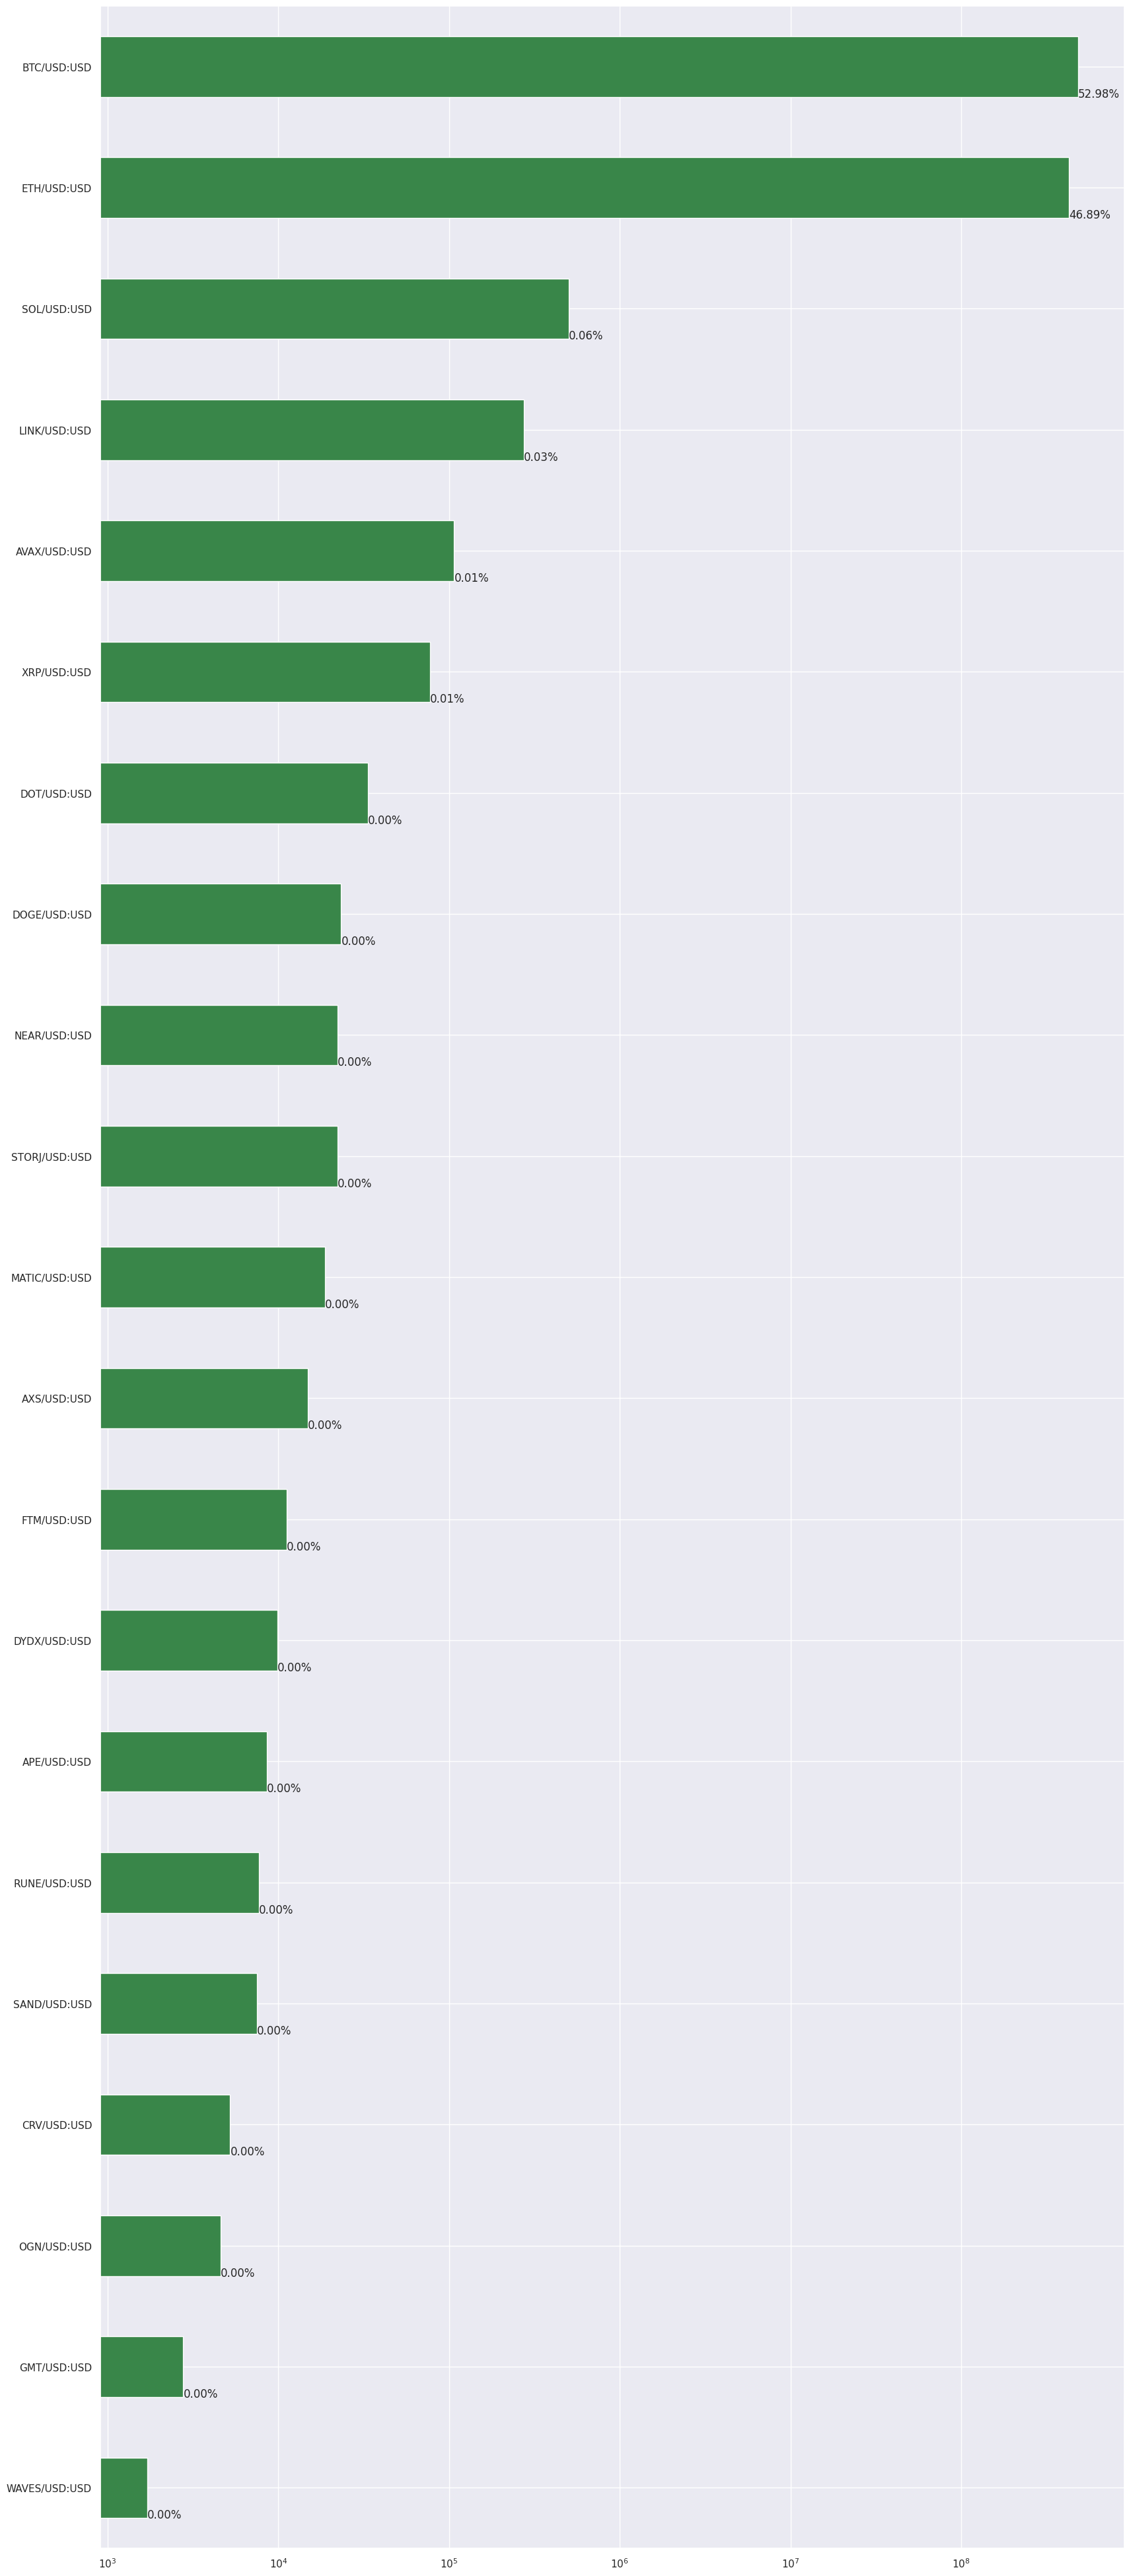

In [335]:
coplotti.plot_barplot(
    mdv_notional,
    annotation_mode="pct",
    orientation="horizontal",
    figsize=[20, 50],
    yscale="log",
)

In [336]:
perp_cry_data.rename(columns={"currency_pair": "full_symbol"}, inplace=True)
cry_timestamp_stats = ramccqa.get_timestamp_stats(perp_cry_data, vendor_name)
cry_timestamp_stats

,min_timestamp,max_timestamp,days_available
APE/USD:USD,2023-12-01 00:00:00,2024-01-01 00:00:00,31
AVAX/USD:USD,2023-12-01 00:00:00,2024-01-01 00:00:00,31
AXS/USD:USD,2023-12-01 00:00:00,2024-01-01 00:00:00,31
BTC/USD:USD,2023-12-01 00:00:00,2024-01-01 00:00:00,31
CRV/USD:USD,2023-12-01 00:00:00,2024-01-01 00:00:00,31
DOGE/USD:USD,2023-12-01 00:00:00,2024-01-01 00:00:00,31
DOT/USD:USD,2023-12-01 00:00:00,2024-01-01 00:00:00,31
DYDX/USD:USD,2023-12-01 00:00:00,2024-01-01 00:00:00,31
ETH/USD:USD,2023-12-01 00:00:00,2024-01-01 00:00:00,31
FTM/USD:USD,2023-12-01 00:00:00,2024-01-01 00:00:00,31


In [337]:
agg_level_full_symbol = ["full_symbol"]
cry_bad_data_stats = ramccqa.get_bad_data_stats(
    perp_cry_data, agg_level_full_symbol, vendor_name
)
cry_bad_data_stats

/app/research_amp/cc/qa.py:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  symbol_data["full_symbol"] = symbol_data["full_symbol"].fillna(


,bad data [%],missing bars [%],volume=0 [%],NaNs [%]
APE/USD:USD,0.073923,0.0,0.073923,0.0
AVAX/USD:USD,1.030443,0.0,1.030443,0.0
AXS/USD:USD,0.627226,0.0,0.627226,0.0
BTC/USD:USD,0.000000,0.0,0.000000,0.0
CRV/USD:USD,0.676508,0.0,0.676508,0.0
DOGE/USD:USD,0.078403,0.0,0.078403,0.0
DOT/USD:USD,0.226249,0.0,0.226249,0.0
DYDX/USD:USD,0.199368,0.0,0.199368,0.0
ETH/USD:USD,0.000000,0.0,0.000000,0.0
FTM/USD:USD,0.141126,0.0,0.141126,0.0


In [338]:
agg_level_full_symbol_year_month = ["full_symbol", "year", "month"]
cry_bad_data_stats_by_year_month = ramccqa.get_bad_data_stats(
    perp_cry_data, agg_level_full_symbol_year_month, vendor_name
)
cry_bad_data_stats_by_year_month

/app/research_amp/cc/qa.py:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  symbol_data["full_symbol"] = symbol_data["full_symbol"].fillna(


bad data [%]  missing bars [%]  volume=0 [%]  NaNs [%]
APE/USD:USD   2023 12      0.073925               0.0      0.073925       0.0
              2024 1       0.000000               0.0      0.000000       0.0
AVAX/USD:USD  2023 12      1.030466               0.0      1.030466       0.0
              2024 1       0.000000               0.0      0.000000       0.0
AXS/USD:USD   2023 12      0.627240               0.0      0.627240       0.0
              2024 1       0.000000               0.0      0.000000       0.0
BTC/USD:USD   2023 12      0.000000               0.0      0.000000       0.0
              2024 1       0.000000               0.0      0.000000       0.0
CRV/USD:USD   2023 12      0.676523               0.0      0.676523       0.0
              2024 1       0.000000               0.0      0.000000       0.0
DOGE/USD:USD  2023 12      0.078405               0.0      0.078405       0.0
              2024 1       0.000000               0.0      0.000000       0.0
DOT/USD:USD   2023 12      0.226254               0.0      0.226254       0.0
              2024 1       0.000000               0.0      0.000000       0.0
DYDX/USD:USD  2023 12      0.199373               0.0      0.199373       0.0
              2024 1       0.000000               0.0      0.000000       0.0
ETH/USD:USD   2023 12      0.000000               0.0      0.000000       0.0
              2024 1       0.000000               0.0      0.000000       0.0
FTM/USD:USD   2023 12      0.141129               0.0      0.141129       0.0
              2024 1       0.000000               0.0      0.000000       0.0
GMT/USD:USD   2023 12      0.656362               0.0      0.656362       0.0
              2024 1       0.000000               0.0      0.000000       0.0
LINK/USD:USD  2023 12      0.038082               0.0      0.038082       0.0
              2024 1       0.000000               0.0      0.000000       0.0
MATIC/USD:USD 2023 12      0.949821               0.0      0.949821       0.0
              2024 1       0.000000               0.0      0.000000       0.0
NEAR/USD:USD  2023 12      1.037186               0.0      1.037186       0.0
              2024 1       0.000000               0.0      0.000000       0.0
OGN/USD:USD   2023 12     12.520161               0.0     12.520161       0.0
              2024 1       0.000000               0.0      0.000000       0.0
RUNE/USD:USD  2023 12     13.371416               0.0     13.371416       0.0
              2024 1       0.000000               0.0      0.000000       0.0
SAND/USD:USD  2023 12      0.383065               0.0      0.383065       0.0
              2024 1       0.000000               0.0      0.000000       0.0
SOL/USD:USD   2023 12      0.586918               0.0      0.586918       0.0
              2024 1       0.000000               0.0      0.000000       0.0
STORJ/USD:USD 2023 12     13.313172               0.0     13.313172       0.0
              2024 1       0.000000               0.0      0.000000       0.0
WAVES/USD:USD 2023 12     12.479839               0.0     12.479839       0.0
              2024 1       0.000000               0.0      0.000000       0.0
XRP/USD:USD   2023 12      0.336022               0.0      0.336022       0.0
              2024 1       0.000000               0.0      0.000000       0.0

/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


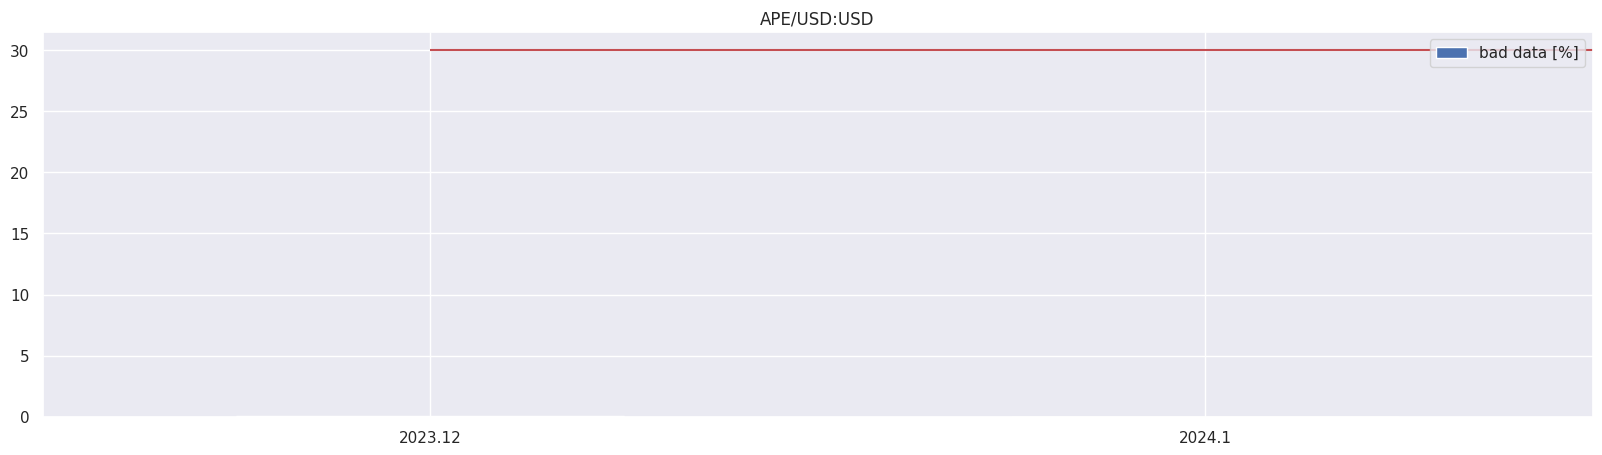

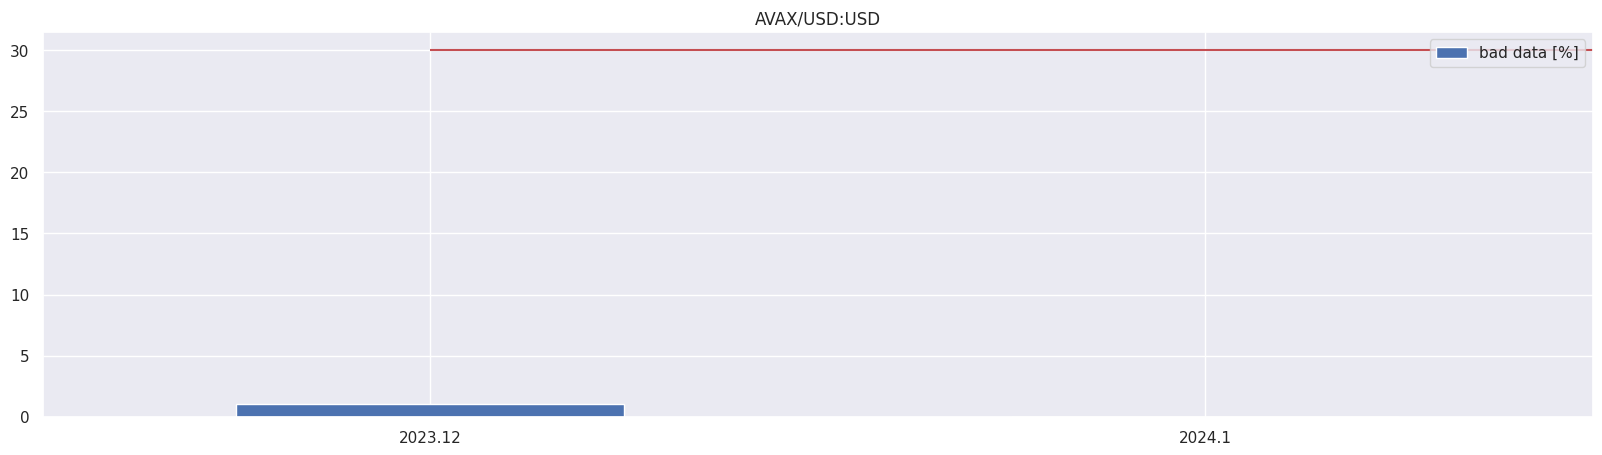

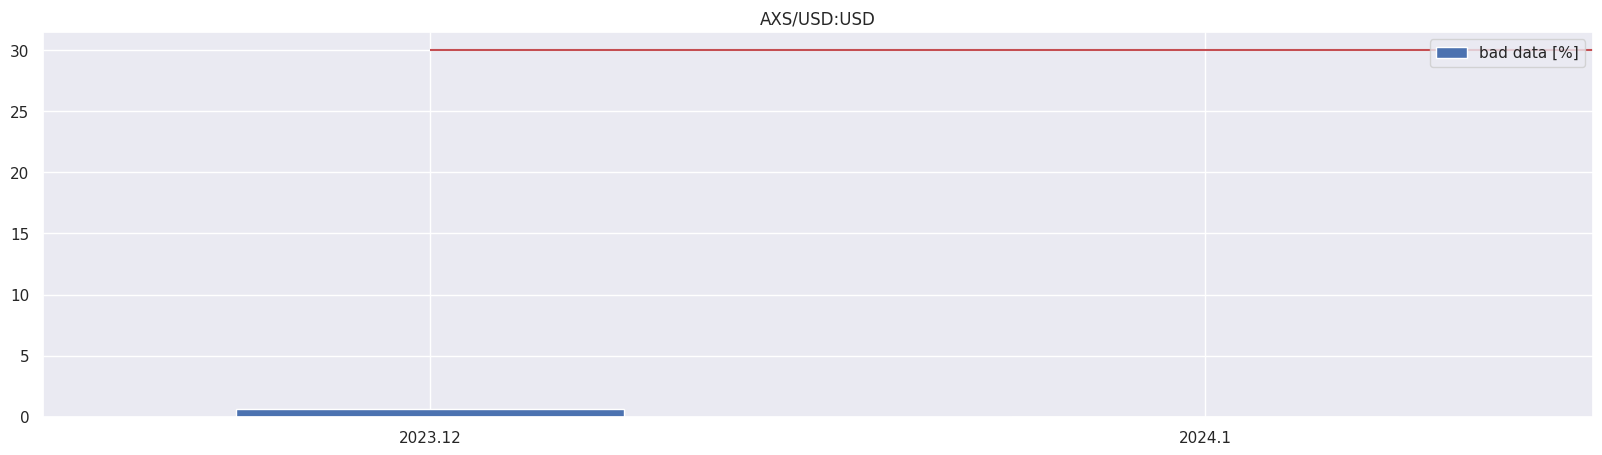

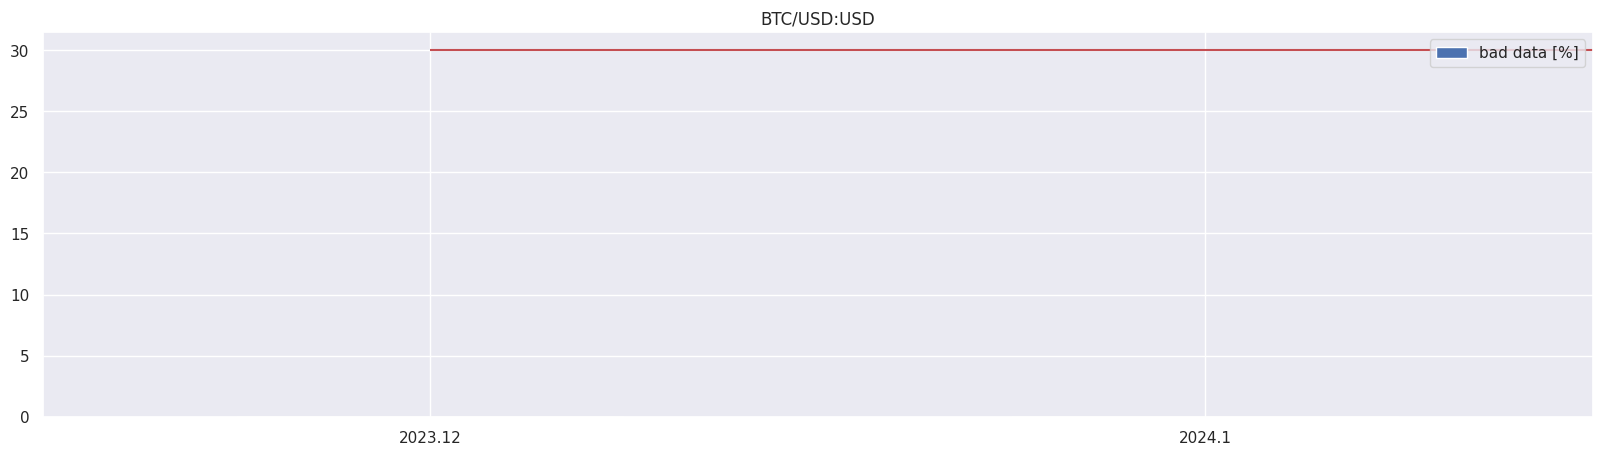

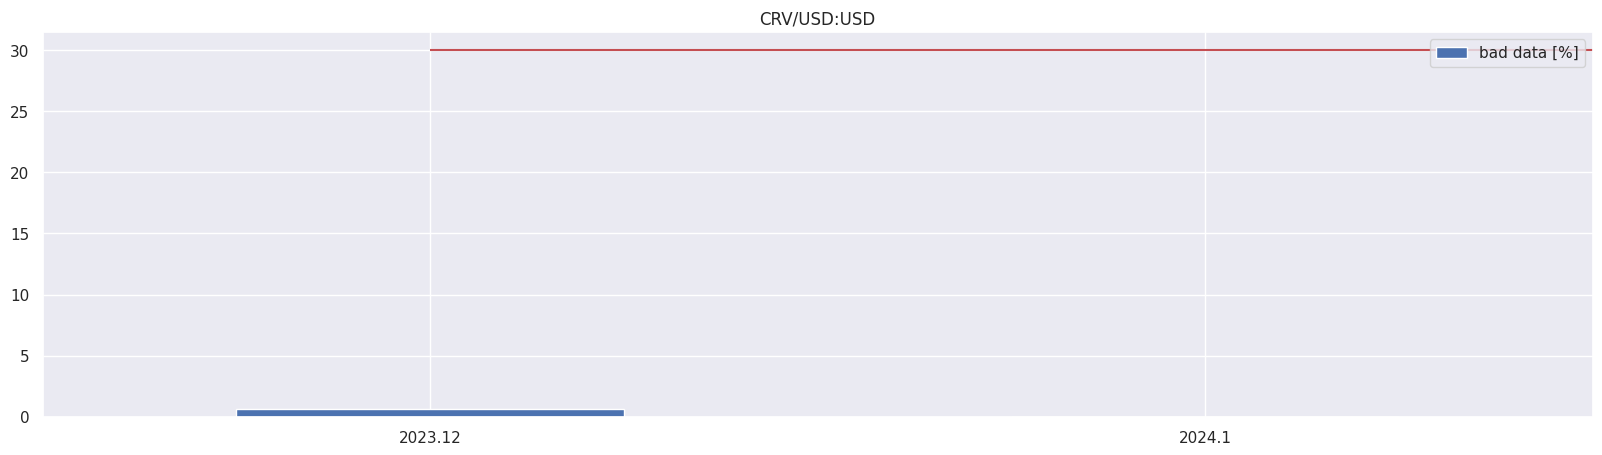

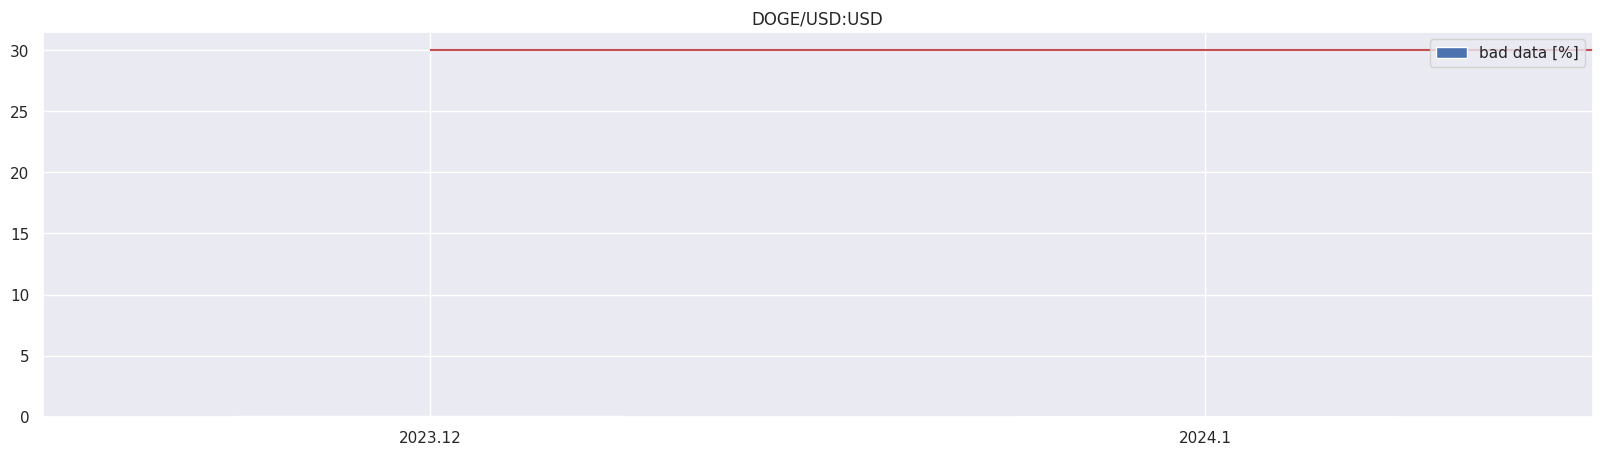

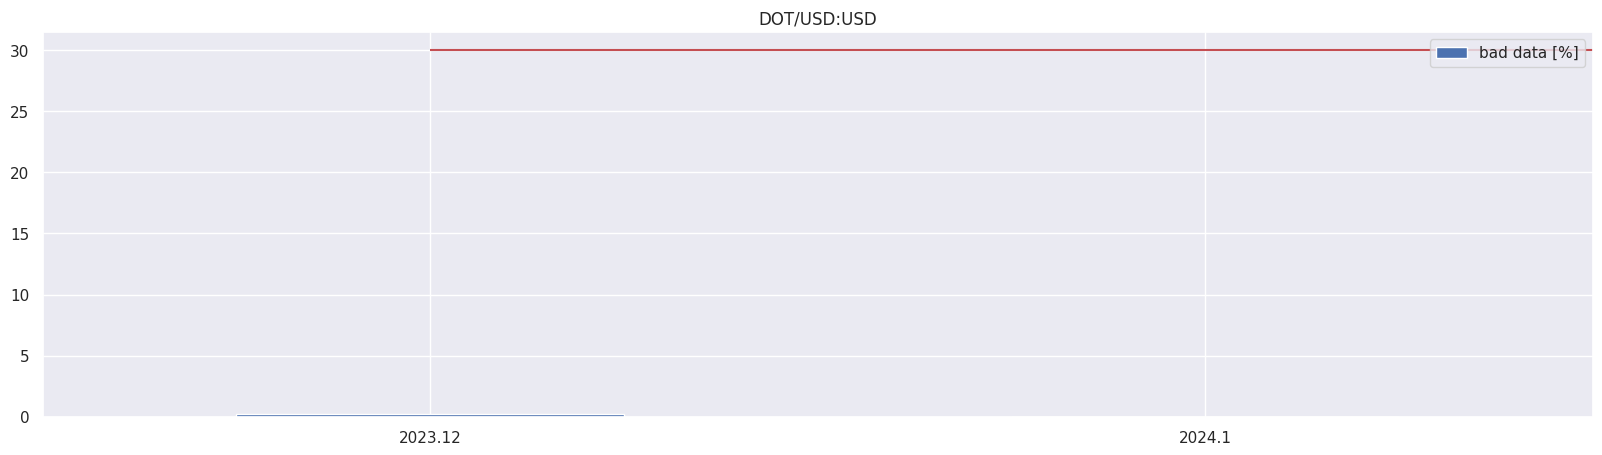

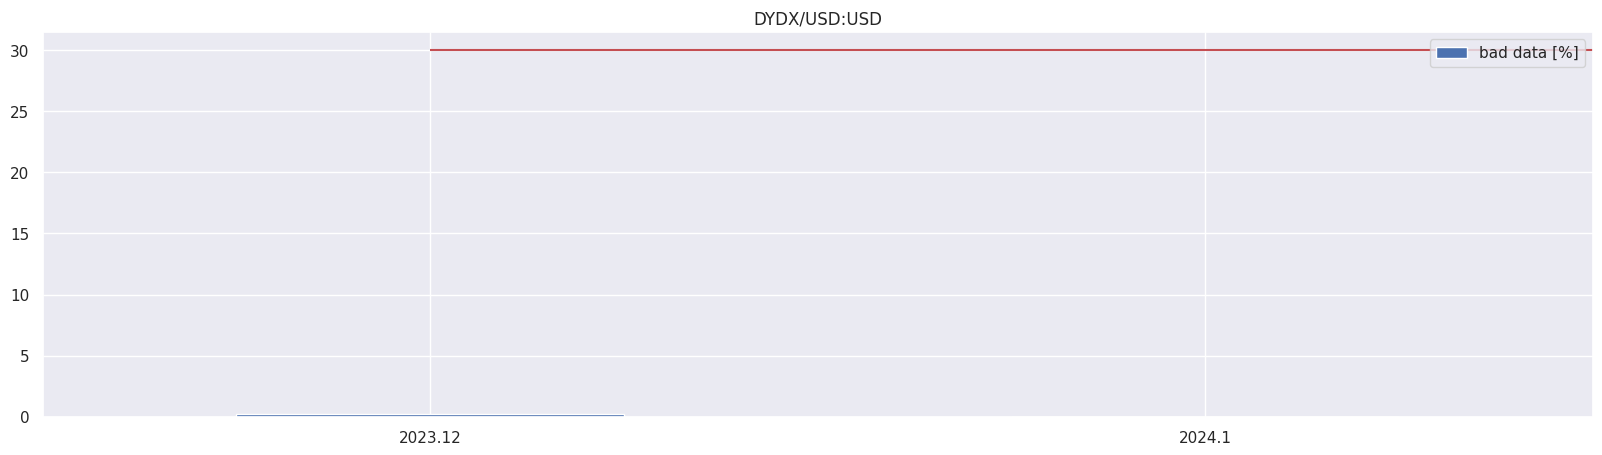

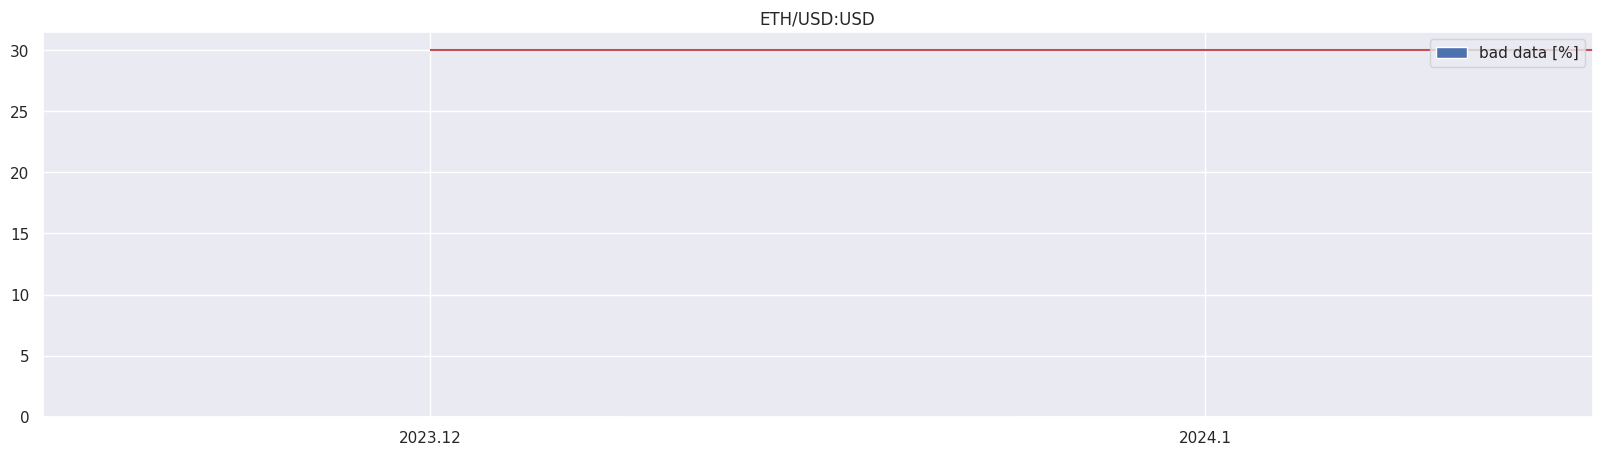

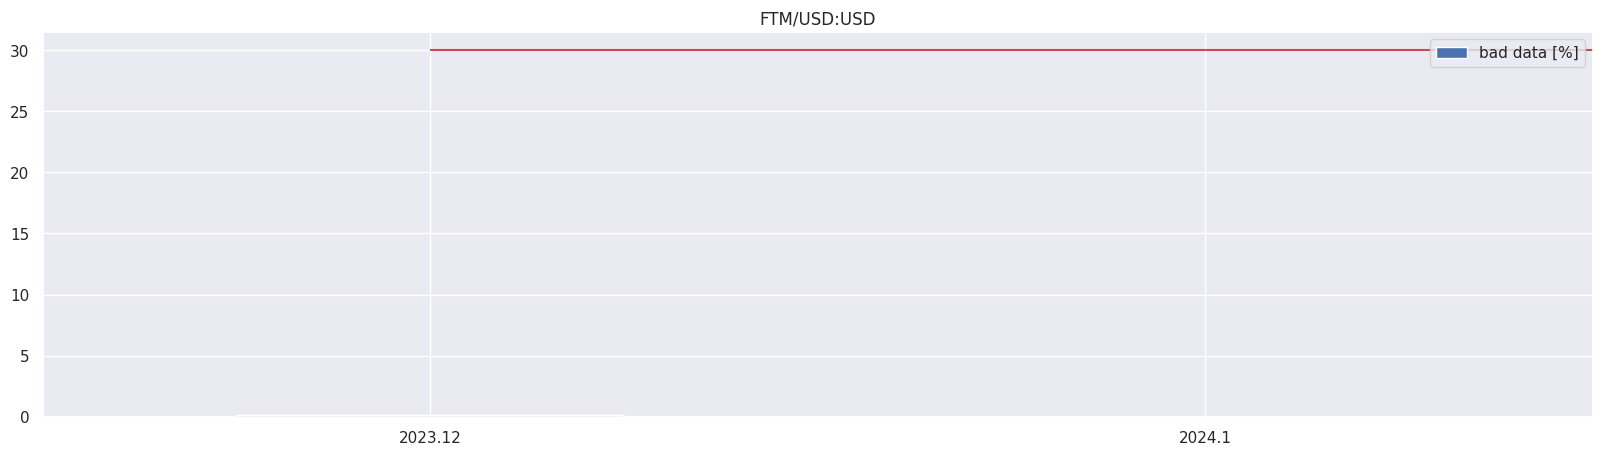

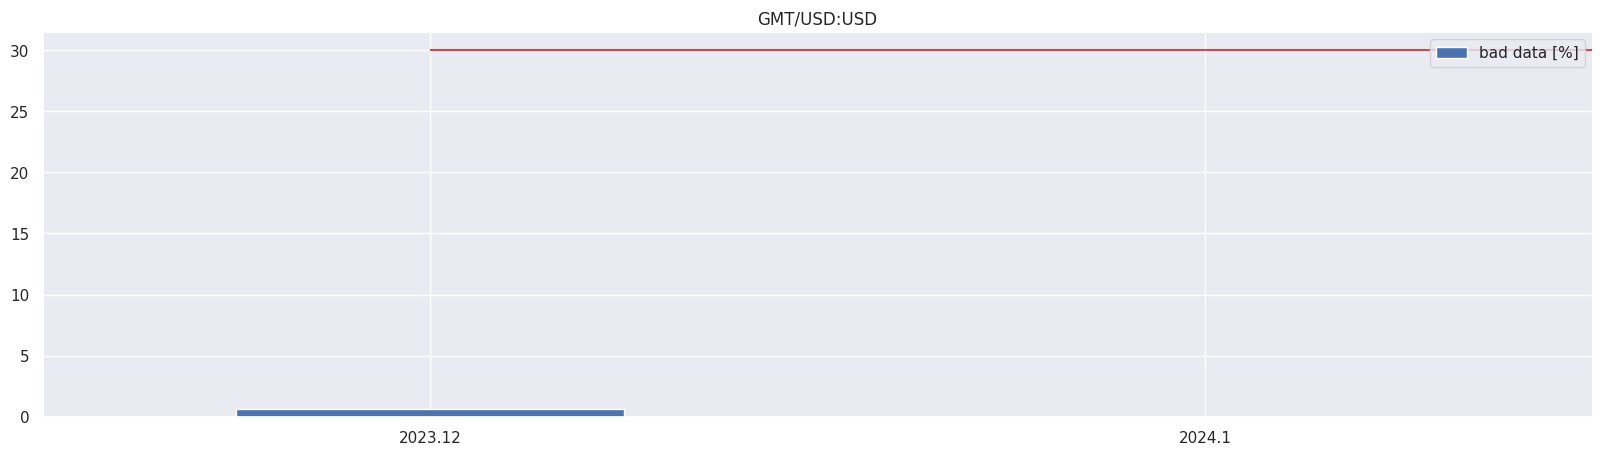

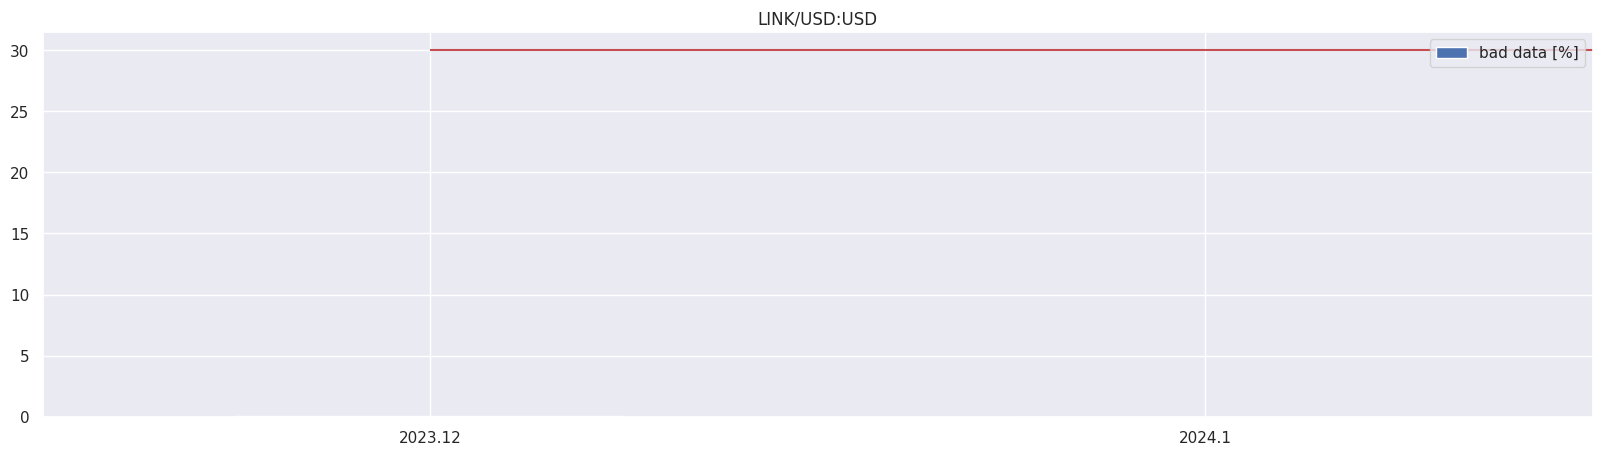

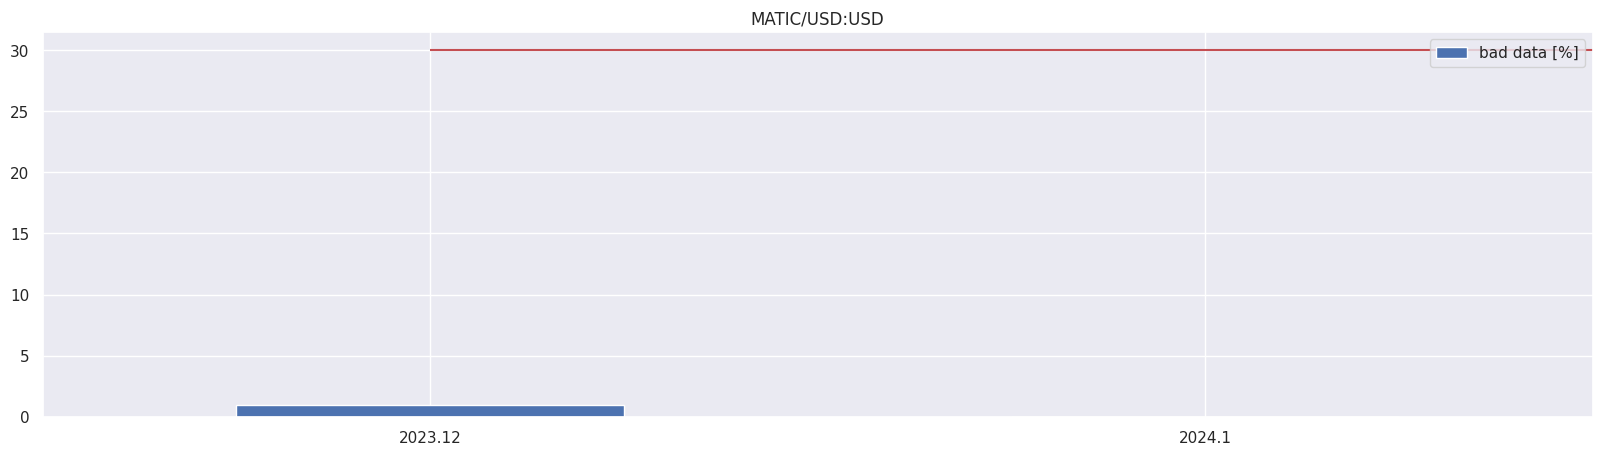

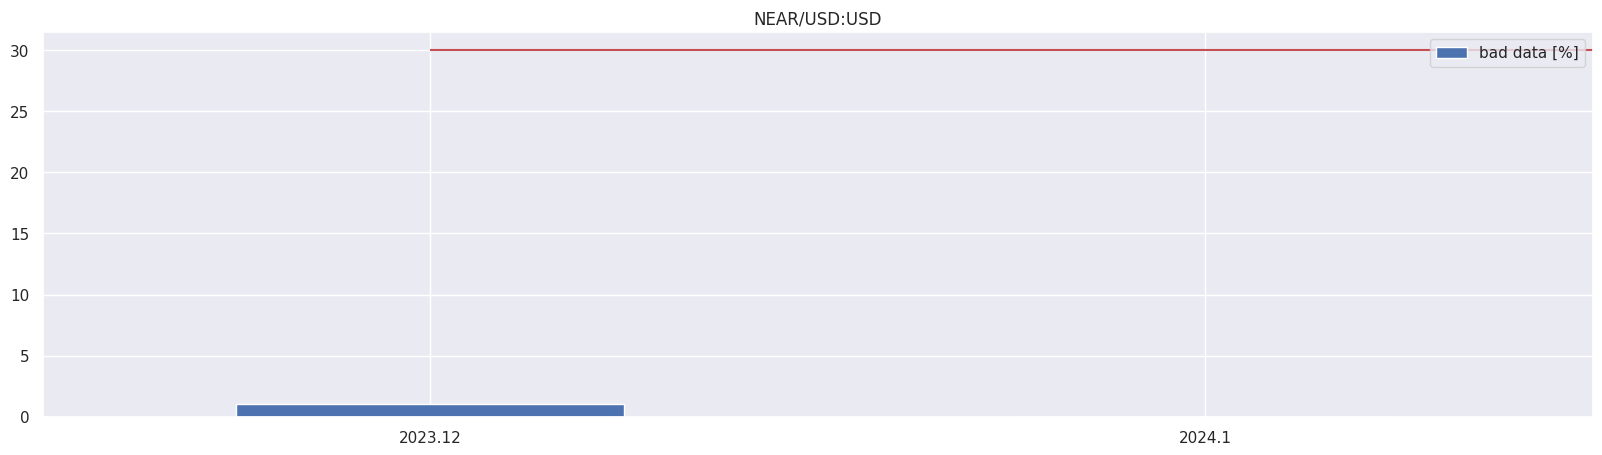

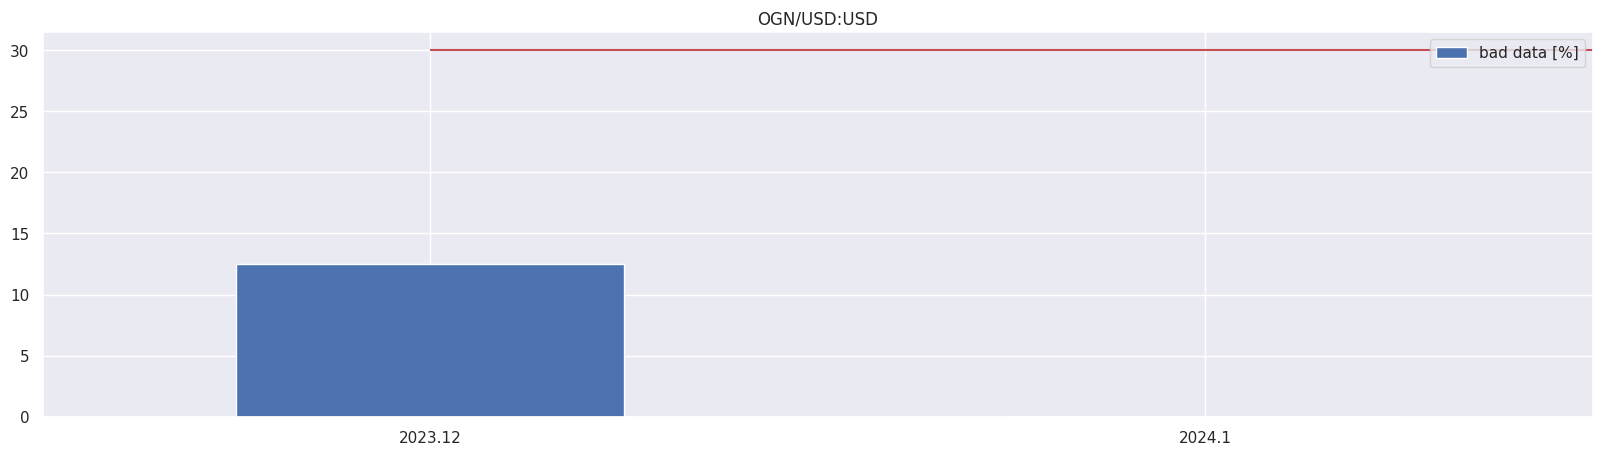

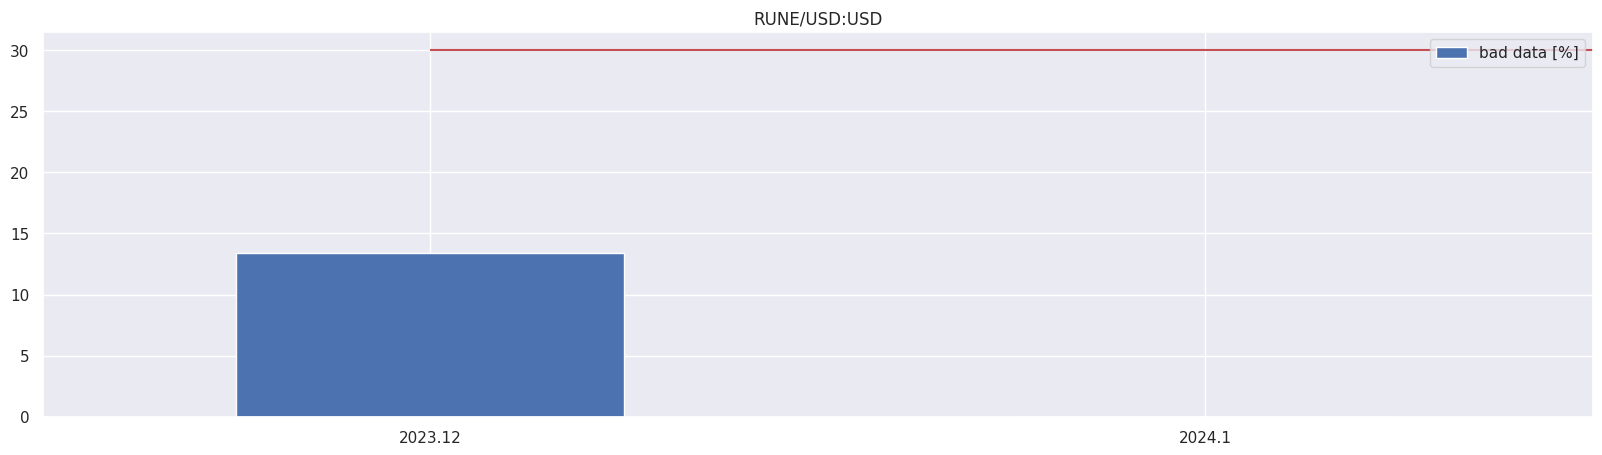

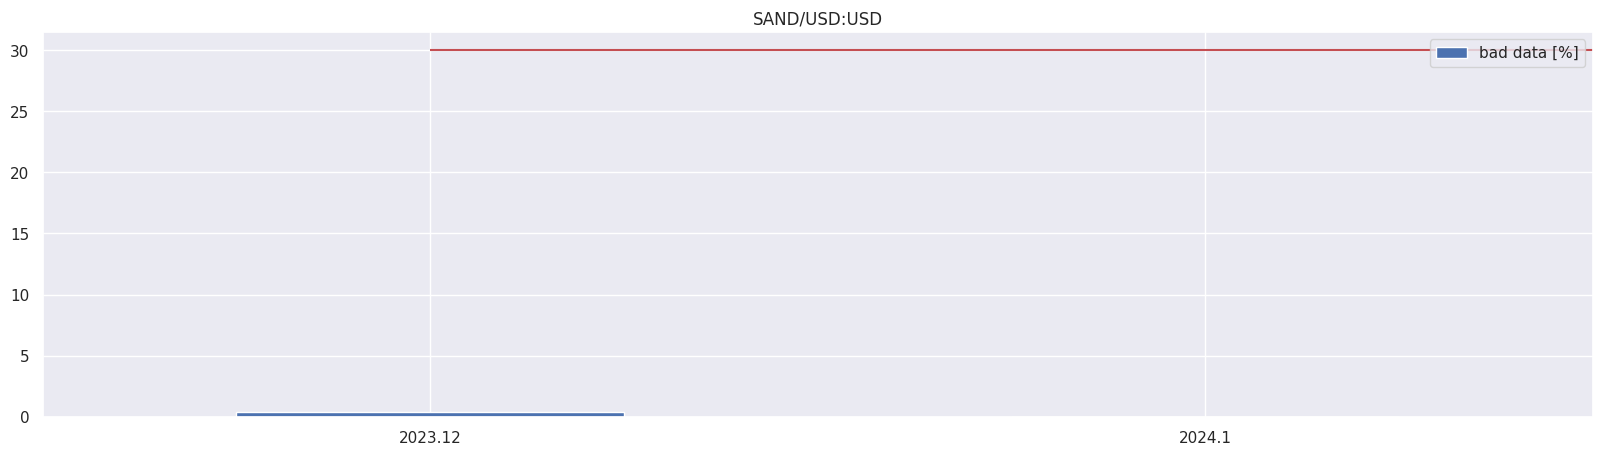

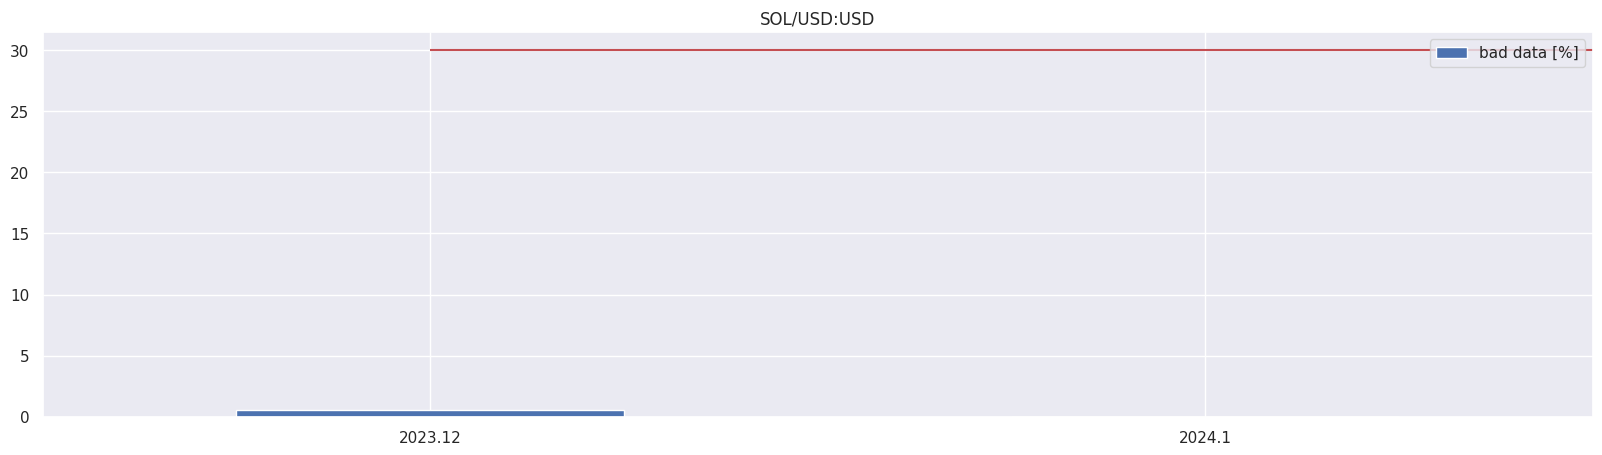

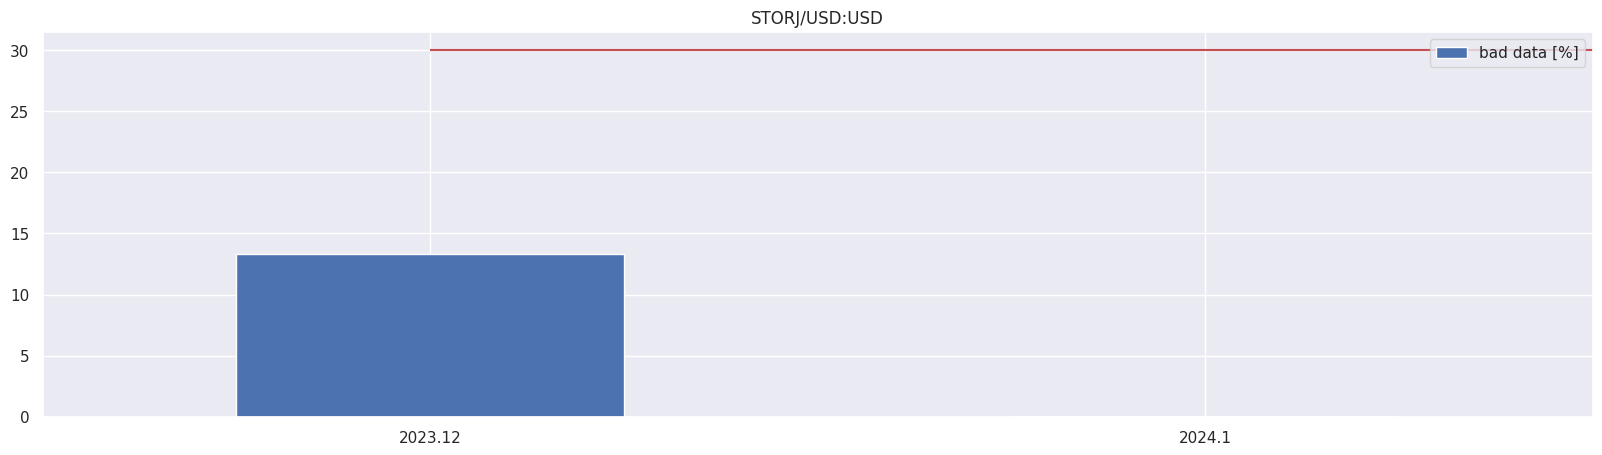

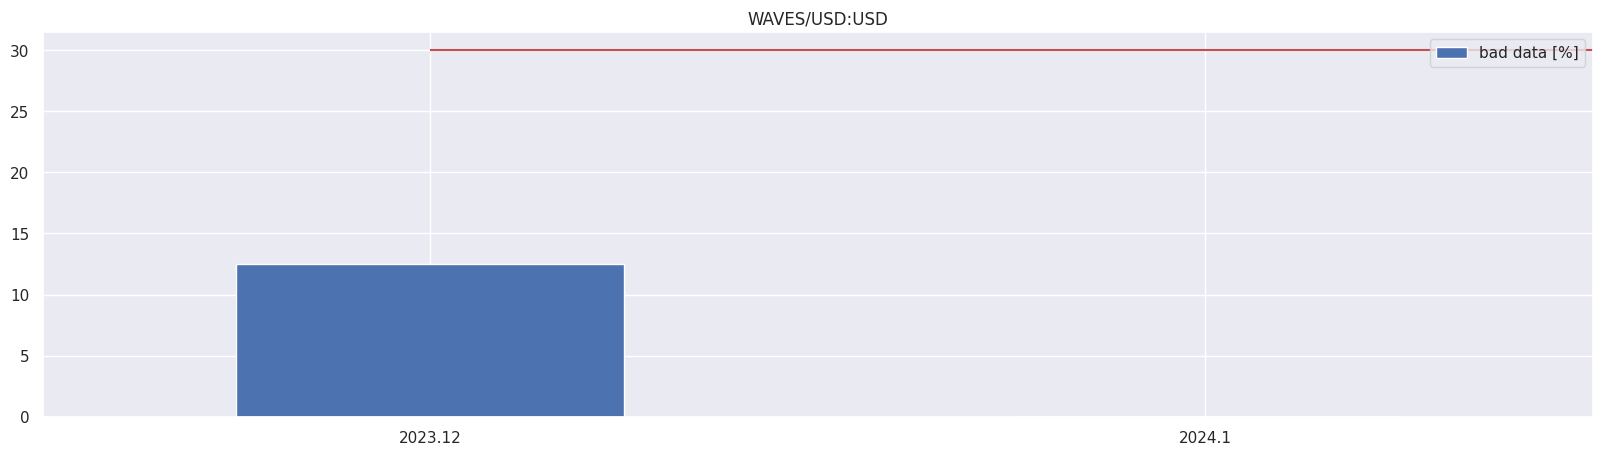

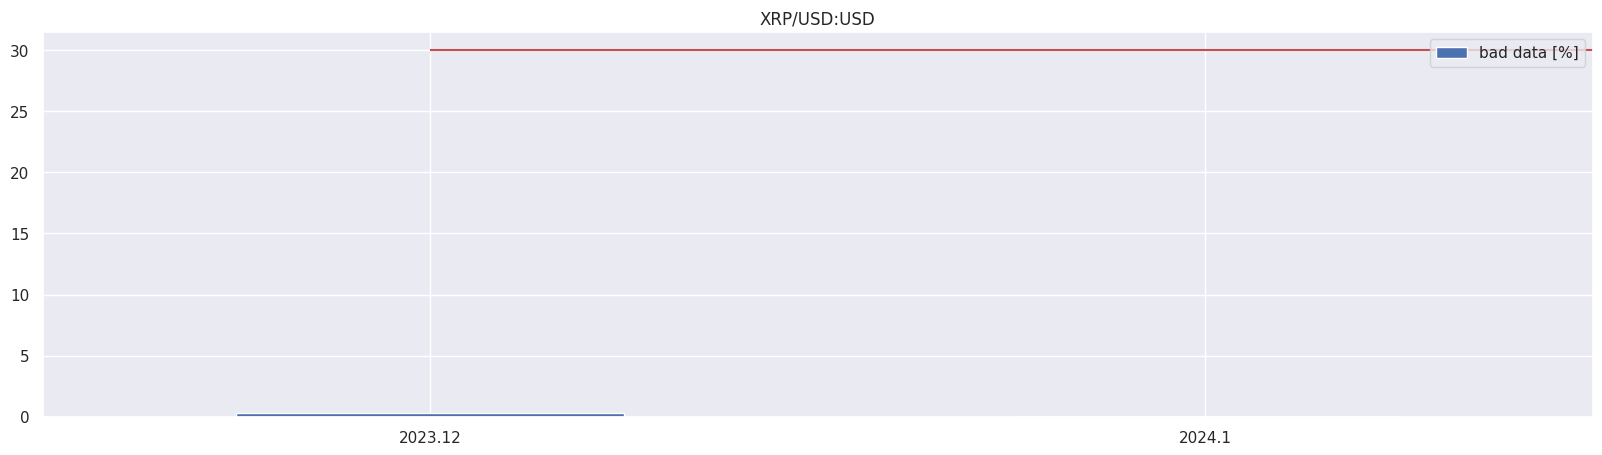

In [339]:
_ = ramccqa.plot_bad_data_by_year_month_stats(
    cry_bad_data_stats_by_year_month, 30
)

# Cryptocom orderbook history data availability

In [139]:
perp_data_hist = pd.DataFrame()
universe_list = [  # Symbols from universe 7.4
    "ETH/USD:USD",  # 2021/03/09
    "BTC/USD:USD",  # 2021/03/09
    "SAND/USD:USD",  # 2021/12
    "STORJ/USD:USD",  # 2022/02
    "GMT/USD:USD",  # 2022/05
    "AVAX/USD:USD",  # 2021/09
    "APE/USD:USD",  # 2022/05
    "MATIC/USD:USD",  # 2021/07
    "DYDX/USD:USD",  # 2021/10
    "DOT/USD:USD",  # 2021/04
    "LINK/USD:USD",  # 2021/05
    "XRP/USD:USD",  # 2021/07
    "CRV/USD:USD",  # 2021/07
    "RUNE/USD:USD",  # 2021/12
    "NEAR/USD:USD",  # 2021/10
    "FTM/USD:USD",  # 2021/10
    "WAVES/USD:USD",  # 2022/02
    "AXS/USD:USD",  # 2021/08
    "OGN/USD:USD",  # 2022/05
    "DOGE/USD:USD",  # 2021/05
    "SOL/USD:USD",  # 2021/07
]
for symbol in universe_list:
    ohlcv = _download_OHLCV_data(
        "2022-05-01T01:00:00+00:00",
        "2022-05-01T03:00:00+00:00",
        symbol,
    )
    print("Completed data collection for ", symbol)
    perp_data_hist = pd.concat([ohlcv, perp_data_hist], ignore_index=True)
perp_data_hist

Completed data collection for  ETH/USD:USD
Completed data collection for  BTC/USD:USD
Completed data collection for  SAND/USD:USD
Completed data collection for  STORJ/USD:USD
Completed data collection for  GMT/USD:USD
Completed data collection for  AVAX/USD:USD
Completed data collection for  APE/USD:USD
Completed data collection for  MATIC/USD:USD
Completed data collection for  DYDX/USD:USD
Completed data collection for  DOT/USD:USD
Completed data collection for  LINK/USD:USD
Completed data collection for  XRP/USD:USD
Completed data collection for  CRV/USD:USD
Completed data collection for  RUNE/USD:USD
Completed data collection for  NEAR/USD:USD
Completed data collection for  FTM/USD:USD
Completed data collection for  WAVES/USD:USD
Completed data collection for  AXS/USD:USD
Completed data collection for  OGN/USD:USD
Completed data collection for  DOGE/USD:USD
Completed data collection for  SOL/USD:USD


,timestamp,open,high,low,close,volume,currency_pair
0,1651366800000,85.182,85.182,85.182,85.182,26.2000,SOL/USD:USD
1,1651366860000,85.224,85.224,85.224,85.224,0.1000,SOL/USD:USD
2,1651366920000,85.374,85.434,85.374,85.434,57.4000,SOL/USD:USD
3,1651366980000,85.428,85.528,85.428,85.528,49.0000,SOL/USD:USD
4,1651367040000,85.397,85.412,85.397,85.412,28.2000,SOL/USD:USD
...,...,...,...,...,...,...,...
2382,1651373760000,2759.340,2759.930,2757.140,2757.190,84.6449,ETH/USD:USD
2383,1651373820000,2757.060,2758.410,2756.880,2757.190,48.2357,ETH/USD:USD
2384,1651373880000,2757.480,2759.110,2756.820,2756.820,63.1624,ETH/USD:USD
2385,1651373940000,2757.180,2759.700,2757.120,2758.740,106.6313,ETH/USD:USD
